# ChartMind: Evaluating Chain-of-Thought Reasoning in Visual Question Answering Using COVID-19 Data Visualizations

This project explores the intersection of **data visualization** and **generative AI** by allowing users to upload a chart (e.g., bar, line, scatter), and then:

1. Automatically generate 2 relevant multiple-choice questions (MCQs).
2. Extract **Chain-of-Thought (CoT)** style reasoning paths for each question.
3. Visualize the reasoning as a **flowchart** to enhance interpretability.

The goal is to make LLM reasoning **visible, understandable**, and **educational** for analysts, students, and decision-makers.

## Cell 1: Install Required libraries

Before running the main code, ensure that all necessary Python libraries are installed.

This cell installs the following packages:
- `google-generativeai`: Access Google Gemini models for LLM and Vision tasks.
- `sentence-transformers`: Used to compute sentence embeddings and similarity scores.
- `wordcloud`: For generating word cloud visualizations from textual reasoning.
- `matplotlib`: Core plotting library for visualizations.
- `graphviz`: Used to render Chain-of-Thought reasoning as flowcharts.

In [1]:
# Install necessary libraries
!pip install google-generativeai sentence-transformers wordcloud matplotlib graphviz

## Cell 2: Importing Core Libraries and Dependencies

This section loads all the necessary libraries for:

- File I/O and text operations
- Image display and visualization
- Data preprocessing and dimensionality reduction
- Word cloud generation and statistical plotting
- Accessing the Gemini Vision/LLM API (Google Generative AI)

In [2]:
# Core modules
import os                  # For interacting with the file system
import re                  # For regular expressions and text cleaning
import textwrap            # For formatting and wrapping text

# Image processing and display
from PIL import Image as PILImage             # To open and manipulate image files
from IPython.display import Image, display    # To display images directly in Jupyter
import matplotlib.pyplot as plt               # For plotting charts and figures
import graphviz                               # For creating flowchart-like visualizations

# Data preprocessing and visualization
from sklearn.feature_extraction.text import CountVectorizer   # For basic NLP text vectorization
from sklearn.decomposition import PCA                         # For dimensionality reduction (e.g., CoT clustering)
from sklearn.preprocessing import StandardScaler              # For scaling data before PCA
import seaborn as sns                                         # For statistical data visualizations
from wordcloud import WordCloud                               # For generating word clouds
import pandas as pd                                           # For data manipulation and tabular analysis
import numpy as np
import matplotlib.patches as mpatches                         # For custom legend entries in visualizations

# Gemini API for Google Generative AI (LLM + Vision)
import google.generativeai as genai           # To access Google Gemini Pro Vision/LLM model

## Cell 3: Setting Up Gemini Vision Model (Google Generative AI)

This cell ensures safe and flexible configuration of the Gemini API in **Google Colab** by:

1. Attempting to load the API key from **Colab's secure `userdata` secrets**.
2. Falling back to **manual input** if the key isn't found.
3. Providing helpful tips on how to store secrets securely.
4. Initializing the `gemini-1.5-pro` multimodal model and testing it with a quick text prompt.

In [3]:
from google.colab import userdata

# Try to load API key securely from Colab's user secrets
try:
    api_key = userdata.get('GEMINI_API_KEY')
    print("API key loaded from Colab secrets")
except:
    # Prompt for key if not found in secrets
    print("Enter your Gemini API key (or leave blank to skip):")
    api_key = input()

    if not api_key:
        print("No API key provided. Some features will be limited.")

# Proceed if API key is available
if api_key:
    os.environ["GEMINI_API_KEY"] = api_key  # Set as environment variable
    genai.configure(api_key=api_key)        # Configure the API

    # Load the Gemini multimodal model (text + image)
    model = genai.GenerativeModel("models/gemini-1.5-pro")
    print("Gemini model ready to use")

    # Perform a quick test to verify the model
    response = model.generate_content("Hello")
    print("Test response:", response.text)
else:
    # Guide user on how to set up Colab secrets
    print("\nTo store your API key securely in Colab:")
    print("1. Click the key icon in the left sidebar")
    print("2. Add a secret named 'GEMINI_API_KEY'")
    print("3. Restart and run again")

API key loaded from Colab secrets
Gemini model ready to use
Test response: Hello! How can I help you today?



##Cell 4: Load and Display Chart Image

This function handles the loading and previewing of a chart image.

Steps:
1. Reads the image from the given path using `PIL`.
2. Converts it to RGB to ensure compatibility with vision models.
3. Displays the chart using `matplotlib`.
4. Returns the image object for further processing by the model.

In [4]:
def load_image(image_path):
    # Open the image file and convert to RGB (in case it's grayscale or CMYK)
    image = PILImage.open(image_path).convert("RGB")

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis("off")            # Hide axis ticks and borders
    plt.title("Uploaded Chart")
    plt.show()

    return image               # Return the image object for model use

## Cell 5: Auto-Generate Title and MCQs from Chart

This function uses the **Gemini Vision model** to analyze the uploaded chart and generate:

- A **descriptive title** summarizing the chart.
- Two **multiple-choice questions (MCQs)**, each with four answer options.

The generated questions help assess the **interpretability** and **reasoning** extracted from the visual.

In [5]:
def generate_mcqs(image, model):
    """
    Prompts Gemini Vision model to generate a title and 2 multiple-choice questions (MCQs)
    from the uploaded chart image.
    """

    # Define the prompt format: includes request for a title and 2 MCQs
    prompt = """
                Give a descriptive title to the uploaded image and generate 2 most relevant multiple-choice questions (MCQs)
                based on the data in the chart. Each question should have four options: a), b), c), d).

                Use this format:
                Title: <Your title>

                Multiple Choice Questions:
                1. <Question>
                    a) <Option A>
                    b) <Option B>
                    c) <Option C>
                    d) <Option D>
                2. <Question>
                    ...
              """

    # Send the prompt and image to the Gemini Vision model
    response = model.generate_content([prompt, image])

    # Return the generated output text
    return response.text

## Cell 6: Extract Chart Title from Gemini's Response

This function parses the **Gemini model's output text** to extract the chart's suggested title.

It looks for the line beginning with `Title:` and retrieves the text that follows. If no title is found, it defaults to `"Untitled"`.

In [6]:
def extract_title(text):
    """
    Extracts the chart title from Gemini's response.

    Args:
        text (str): Full response string from Gemini including title and MCQs.

    Returns:
        str: Extracted title or "Untitled" if not found.
    """
    # Use regex to find a line starting with 'Title:' and capture what's after it
    match = re.search(r"Title:\s*(.+)", text)

    # Return the matched title or default to 'Untitled'
    return match.group(1).strip() if match else "Untitled"

## Cell 7: Parse Multiple Choice Questions from Gemini Output

This function extracts structured MCQs from Gemini’s raw text output.

It assumes the format:
1. <Question> a) <Option A> b) <Option B> c) <Option C> d) <Option D>
2. ...


Returns a list of tuples:
```python
(question, option_a, option_b, option_c, option_d)


In [7]:
def parse_questions(question_text):
    """
    Parses plain text MCQs from Gemini's response.

    Expected format:
    1. <Question>
        a) ...
        b) ...
        c) ...
        d) ...

    Returns:
        list of tuples: [(question, a, b, c, d), ...]
    """
    # Define regex pattern to extract question + 4 options
    pattern = r"\d+\.\s(.+?)\s+a\)\s(.+?)\s+b\)\s(.+?)\s+c\)\s(.+?)\s+d\)\s(.+?)(?:\n|$)"

    # Find all matching groups and return them
    matches = re.findall(pattern, question_text, re.DOTALL)
    return matches

## Cell 8: Generate Chain-of-Thought (CoT) Reasoning and Visual Flowcharts

This function uses the Gemini Vision model to:

1. Generate **step-by-step reasoning** (CoT) for each multiple-choice question.
2. Optionally use the image for context (multimodal reasoning).
3. Render a **flowchart** for each reasoning path using Graphviz.

**Inputs:**
- `question_blocks`: list of tuples from `parse_questions()`
- `model`: the configured Gemini LLM or Vision model
- `image`: the chart (optional)
- `image_path`: used for naming and saving flowcharts

**Outputs:**
- `reasonings`: a list of textual CoT responses (for evaluation, saving, etc.)


In [8]:
def generate_reasoning(question_blocks, model, image=None, image_path=None):
    """
    Generate Chain-of-Thought reasoning and render flowcharts for each MCQ.

    Parameters:
    - question_blocks: list of tuples (question, a, b, c, d)
    - model: Gemini vision model instance
    - image: optional chart image (for multimodal prompts)
    - image_path: used to name and save CoT graphs

    Returns:
    - reasonings: list of step-by-step reasoning responses (or errors)
    """
    reasonings = []  # Store final CoT outputs

    for i, (q_text, opt_a, opt_b, opt_c, opt_d) in enumerate(question_blocks, 1):
        # Format question and options into a unified prompt
        full_question = (
            f"Q{i}: {q_text.strip()}\n"
            f"A) {opt_a.strip()}\n"
            f"B) {opt_b.strip()}\n"
            f"C) {opt_c.strip()}\n"
            f"D) {opt_d.strip()}"
        )

        # Prompt for step-by-step reasoning
        cot_prompt = f"""
                          You are given a visual image. Based on its content, answer the following multiple-choice question using step-by-step reasoning.

                          {full_question}

                          Please explain your reasoning step by step and conclude with the correct option (A/B/C/D).
                      """

        try:
            # Include the image if available
            content_input = [cot_prompt, image] if image else [cot_prompt]
            cot_response = model.generate_content(content_input)
            cot_answer = cot_response.text  # Extract CoT text

        except Exception as e:
            print(f"Vision model failed for Q{i}: {str(e)}")
            cot_answer = f"Vision model failed: {e}"
            reasonings.append(cot_answer)
            continue

        # Display the CoT for user inspection
        print(f"\nChain-of-Thought Reasoning for Q{i}:\n")
        print(cot_answer, "\n" + "-" * 80 + "\n")

        try:
            # Parse reasoning steps into a list and render a flowchart
            steps = parse_cot_steps(cot_answer)
            render_final_cot_graph(steps, i, image_path)
        except Exception as viz_err:
            print(f"Failed to render CoT graph for Q{i}: {viz_err}")

        reasonings.append(cot_answer)

    return reasonings

## Cell 9: Parse Chain-of-Thought into Reasoning Steps

This function processes the **raw Chain-of-Thought (CoT)** output from Gemini to extract clean, step-by-step reasoning.

It handles:
- Numbered or bulleted steps
- Plain paragraphs split by newlines
- Cleaning out headers like `"Chain-of-Thought Reasoning:"`
- Normalizing the final answer statement (e.g., replacing LaTeX `\boxed{}` with `"Final Answer:"`)

In [9]:
def parse_cot_steps(cot_text):
    """
    Splits the Chain-of-Thought (CoT) reasoning into individual steps.

    Handles various formats:
    - Numbered steps (1., 2., etc.)
    - Bullet points or newline-separated logic
    - Final answers formatted with LaTeX or plain text
    """
    cot_text = cot_text.strip()  # Clean up whitespace

    # Remove any header-like prefix such as "Chain-of-Thought Reasoning:"
    cot_text = re.sub(r"(Chain-of-Thought Reasoning\s*[:\-]*)", "", cot_text, flags=re.I)

    # Break reasoning into lines
    lines = cot_text.split("\n")
    steps = []

    for line in lines:
        line = line.strip()
        if not line:
            continue  # Skip empty lines

        # Normalize any LaTeX final answers (e.g., $\boxed{A}$)
        line = re.sub(r"\$\\boxed\{[A-D]\}\$", r"Final Answer", line)

        # Ensure consistent final answer format
        line = re.sub(r"Final Answer\s*[:\-]*", "Final Answer:", line, flags=re.I)

        steps.append(line)  # Add cleaned line to steps

    return steps  # List of step-by-step reasoning lines

## Cell 10: Visualize CoT Reasoning as a Flowchart

This function renders a **flowchart** representing step-by-step Chain-of-Thought (CoT) reasoning using `graphviz`.

Key Features:
- Creates a **title node** for the question.
- Breaks down each reasoning step and wraps long text.
- Automatically draws arrows between reasoning steps.
- Saves and displays the flowchart as a PNG.

Output is saved as:  
`<image_name>_cot_graph_q<question_number>.png`

In [10]:
def render_final_cot_graph(steps, q_number, image_path):
    """
    Render a reasoning flowchart from step-by-step CoT output.

    Args:
        steps (list): List of reasoning steps (strings)
        q_number (int): Question number for labeling
        image_path (str): Used to extract base name for saving the flowchart
    """
    # Extract base image name (without extension) for naming the output file
    image_base = os.path.splitext(os.path.basename(image_path))[0]

    # Initialize the directed graph
    dot = graphviz.Digraph(comment=f"CoT Q{q_number}")
    dot.attr(rankdir='TB', fontsize='10', nodesep='0.4', ranksep='0.5')  # Top-to-bottom layout

    # Add a title node at the top of the graph
    dot.node("TITLE", f"Chain-of-Thought for Q{q_number}", shape='plaintext',
             fontname='Helvetica-Bold', fontsize='12')

    # Set global style for nodes and edges
    dot.attr('node', shape='box', style='rounded,filled', fillcolor='#ffffcc',
             fontname='Helvetica', fontsize='10')
    dot.attr('edge', arrowsize='0.6')

    # Add reasoning steps one by one as nodes and link them
    step_id = 0
    last_node = "TITLE"

    for step in steps:
        # Optionally split complex steps into substeps for cleaner flowcharts
        substeps = re.split(r'(?<=[\.\:])\s+(?=[A-Z0-9])', step.strip())

        for sub in substeps:
            # Wrap text for better node readability
            clean = "\n".join(textwrap.wrap(sub.strip(), width=60))

            node_name = f"S{step_id}"
            dot.node(node_name, clean)     # Add node
            dot.edge(last_node, node_name) # Draw arrow from last step
            last_node = node_name
            step_id += 1

    # Construct filename using base image name and question number
    filename = f"/content/{image_base.lower()}_cot_graph_q{q_number}"

    # Save and render as PNG, don't open viewer automatically
    dot.render(filename, format='png', view=False)

    # Display in notebook
    display(Image(filename + ".png"))

## Cell 11: Full ChartMind Pipeline Execution

This function runs the **entire ChartMind workflow** from start to finish:

1. Load and display the uploaded chart.
2. Use Gemini Vision to generate a **chart title** and **2 MCQs**.
3. Parse the multiple-choice questions.
4. Generate **step-by-step reasoning** for each question (Chain-of-Thought).
5. Render each reasoning path as a **flowchart** for visual interpretability.

**Returns:**
- `questions`: list of parsed MCQs
- `reasonings`: list of Chain-of-Thought responses (1 per question)

In [11]:
def run_pipeline(image_path, model):
    """
    Full ChartMind pipeline:
    1. Load chart image
    2. Generate title and MCQs
    3. Parse questions
    4. Generate CoT reasoning
    5. Render visual flowcharts
    """
    # Step 1: Load and show chart
    image = load_image(image_path)

    # Step 2: Title + MCQs
    question_text = generate_mcqs(image, model)
    print(question_text)

    # Step 2.5: Extract and display chart title
    title = extract_title(question_text)
    # print(f"\nChart Title: {title}")

    # Step 3: Parse MCQs
    questions = parse_questions(question_text)

    if not questions:
        print("No questions found. Check model output format.")
        return [], []

    # Step 4: Generate CoT reasoning (with graph) for each question
    print("\nGenerating Chain-of-Thought Reasoning...\n")
    reasonings = generate_reasoning(
        question_blocks=questions,
        model=model,
        image=image,
        image_path=image_path
    )

    return questions, reasonings

## Cell 12: Example of execution

The cells below (12.1 - 12.10) demonstrates how to run the full ChartMind pipeline on a sample chart image.

**Input:**
- Chart Image: `image.png`

**Process:**
1. Loads and displays the image.
2. Generates a descriptive title and 2 MCQs using Gemini Vision.
3. Parses each question and options.
4. Extracts step-by-step reasoning via Chain-of-Thought.
5. Renders a flowchart for each question's reasoning path.

**Output:**
- List of structured questions
- List of reasoning paths
- Graphical CoT flowcharts


### Cell 12.1: COVID-19 Global Spread (Radial Overview)

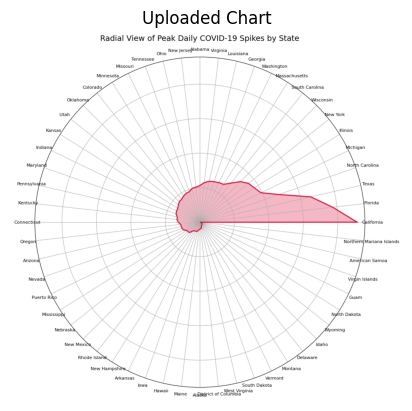

Title: Radial Visualization of Peak Daily COVID-19 Cases by US State

Multiple Choice Questions:

1. Which group of states experienced their peak daily COVID-19 cases roughly at the same time?
    a) California, Texas, Florida
    b) New York, Illinois, Michigan
    c) Washington, Massachusetts, South Carolina
    d) Minnesota, Colorado, Oklahoma

2.  Which state experienced its peak daily COVID-19 cases latest compared to the other options?
    a) California
    b) Florida
    c) Texas
    d) New York


Generating Chain-of-Thought Reasoning...


Chain-of-Thought Reasoning for Q1:

The shaded region on the radial chart represents states whose peak daily COVID-19 cases occurred roughly at the same time. The states within this region are Texas, Florida, and California.

Thus, the correct answer is A. 
--------------------------------------------------------------------------------



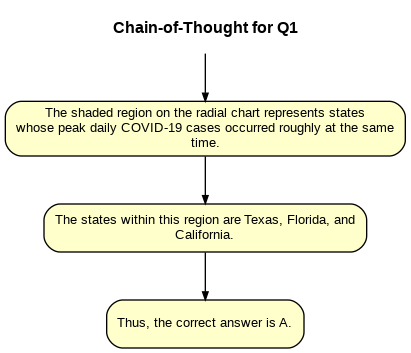


Chain-of-Thought Reasoning for Q2:

The radial chart shows the timing of peak COVID-19 cases by state. The earliest peaks are at the center, and the timing moves outwards towards later dates.

1. **Locate the states:** We find California, Florida, Texas, and New York on the chart.

2. **Compare their positions:** California is furthest from the center, followed by Florida, then Texas, and New York is closest to the center.

3. **Interpret the positions:** Since the chart radiates outwards from the earliest peak to the latest, California's position furthest from the center means it had its peak the latest out of the options.

Final Answer: The final answer is $\boxed{A}$ 
--------------------------------------------------------------------------------



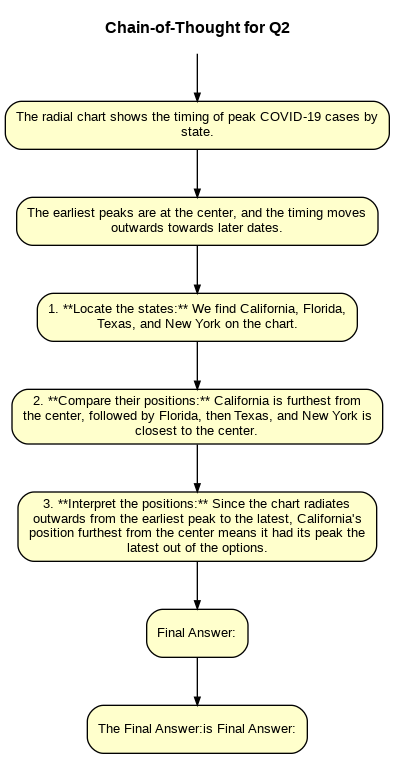

In [12]:
questions, reasonings = run_pipeline("/content/Covid_Radial.png", model)

### Cell 12.2: Annotated Timeline of COVID-19

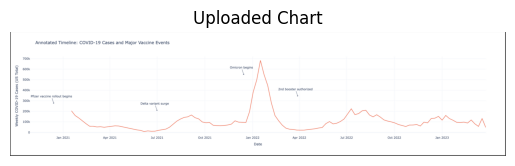

Title: Weekly COVID-19 Cases in the US and Key Vaccine Events (2021-2023)

Multiple Choice Questions:

1.  Around which date did weekly COVID-19 cases reach their peak during the Omicron surge?
    a) October 2021
    b) January 2022
    c) April 2022
    d) July 2022

2. Which of the following events occurred closest to the lowest point of weekly COVID-19 cases between the Delta and Omicron surges?
    a) Pfizer vaccine rollout begins
    b) Delta variant surge
    c) Omicron begins
    d) 2nd booster authorized


Generating Chain-of-Thought Reasoning...


Chain-of-Thought Reasoning for Q1:

The graph shows a sharp peak in COVID-19 cases around the time "Omicron begins" is marked.  This mark falls between Oct 2021 and Apr 2022. The peak appears to be aligned with January 2022.

Therefore, the correct option is B) January 2022. 
--------------------------------------------------------------------------------



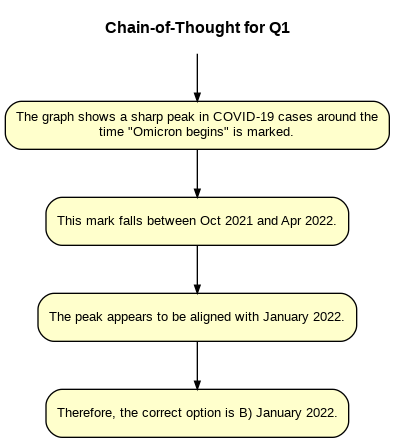


Chain-of-Thought Reasoning for Q2:

The graph shows a clear dip in COVID-19 cases between the Delta and Omicron surges. This low point occurred in the late fall/early winter of 2021, approximately around November/December 2021.

* **A) Pfizer vaccine rollout begins:** This occurred in early 2021, well before the low point between Delta and Omicron.

* **B) Delta variant surge:** The Delta surge peaked in the summer of 2021 and then declined. The low point we are looking for occurred *after* the Delta surge.

* **C) Omicron begins:** The Omicron surge began in late 2021/early 2022 and caused cases to rapidly increase, after the low point we're identifying.

* **D) 2nd booster authorized:** This occurred in the spring of 2022, months after the low point.

The closest event to the low point between Delta and Omicron is when **Omicron begins (C)**. While it started rising immediately after the low point, its beginning marks the end of the brief lull in cases.

Final Answer: The final answ

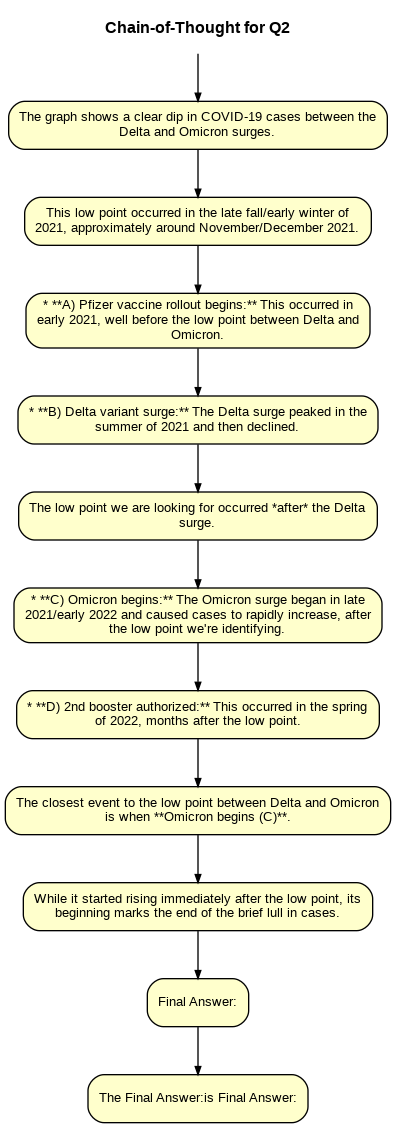

In [13]:
questions, reasonings = run_pipeline("/content/Annotated_covid_TL.png", model)

### 12.3: Daily Case Trends Across Regions

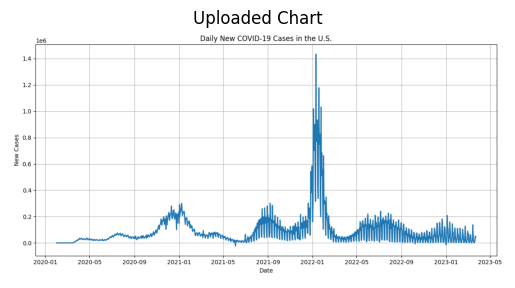

Title: Daily New COVID-19 Cases in the U.S. (2020-2023)

Multiple Choice Questions:
1. During which period did the U.S. experience the highest peak of daily new COVID-19 cases?
    a) Early 2021
    b) Early 2022
    c) Early 2023
    d) Mid 2020
2. Approximately how many daily new COVID-19 cases were reported at the peak in early 2022?
    a) 200,000
    b) 600,000
    c) 1,000,000
    d) 1,400,000


Generating Chain-of-Thought Reasoning...


Chain-of-Thought Reasoning for Q1:

The graph shows daily new COVID-19 cases in the U.S. over time.

1. **Locate the highest peak:** The highest peak on the graph occurs roughly between late 2021 and early 2022.

2. **Compare with options:**
   - A) Early 2021: There's a peak in early 2021, but it is not the highest.
   - B) Early 2022: This period corresponds to the highest peak on the graph.
   - C) Early 2023:  Cases are much lower in early 2023.
   - D) Mid 2020: Cases were relatively low in mid-2020.

Final Answer: The final answer is $\boxe

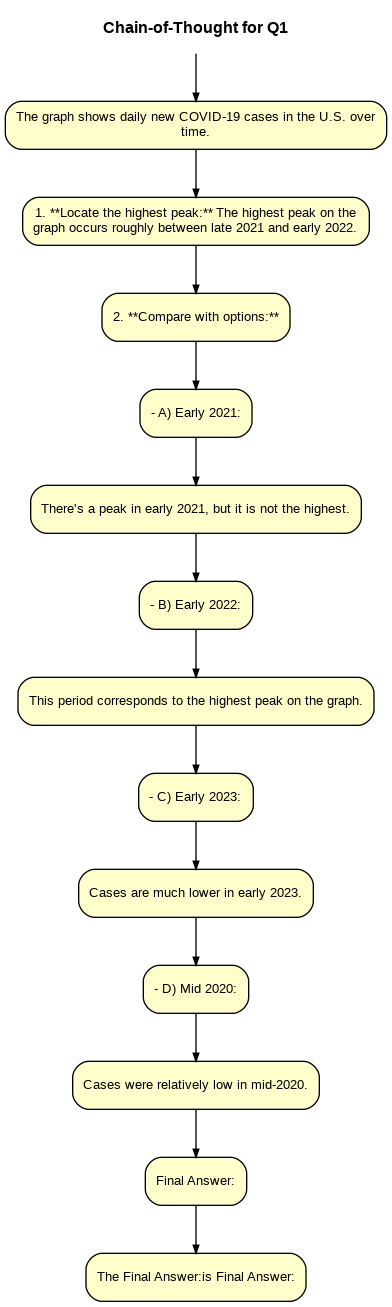


Chain-of-Thought Reasoning for Q2:

The graph shows the daily new COVID-19 cases in the U.S. The question asks about the peak in early 2022.  The peak appears to be slightly above the 1,400,000 gridline, suggesting it is somewhat above that level.
A) 200,000
B) 600,000
C) 1,000,000
D) 1,400,000

The peak appears closest to 1,400,000.

Final Answer: The final answer is $\boxed{D}$ 
--------------------------------------------------------------------------------



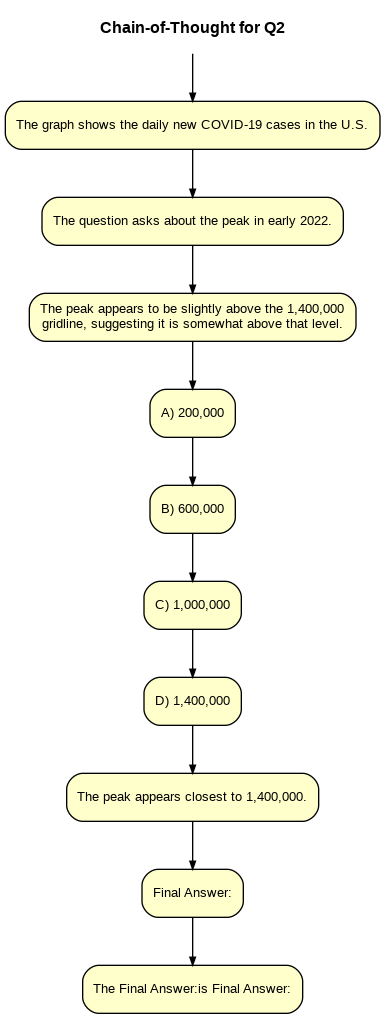

In [14]:
questions, reasonings = run_pipeline("/content/Daily_Covid.png", model)

### 12.4: Early Outbreak Patterns in COVID-19

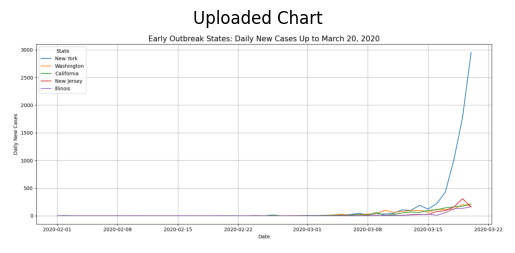

Title: Daily New COVID-19 Cases in Early Outbreak States (Up to March 20, 2020)

Multiple Choice Questions:

1. Which state experienced the largest increase in daily new cases by March 20, 2020?
    a) Washington
    b) California
    c) New York
    d) Illinois

2. Around what date did daily new cases in New York start to significantly increase?
    a) February 20, 2020
    b) March 1, 2020
    c) March 8, 2020
    d) March 15, 2020


Generating Chain-of-Thought Reasoning...


Chain-of-Thought Reasoning for Q1:

The graph shows the daily new cases of COVID-19 up to March 20, 2020, for several states. We are looking for the state with the largest increase in daily new cases by that date.

1. Observe the trends for each state on the graph.  Notice that New York's line shows a very steep increase towards March 20, 2020, reaching close to 3000 daily new cases.
2. Compare New York's trend with the other states. Washington, California, New Jersey, and Illinois all have significantly lower d

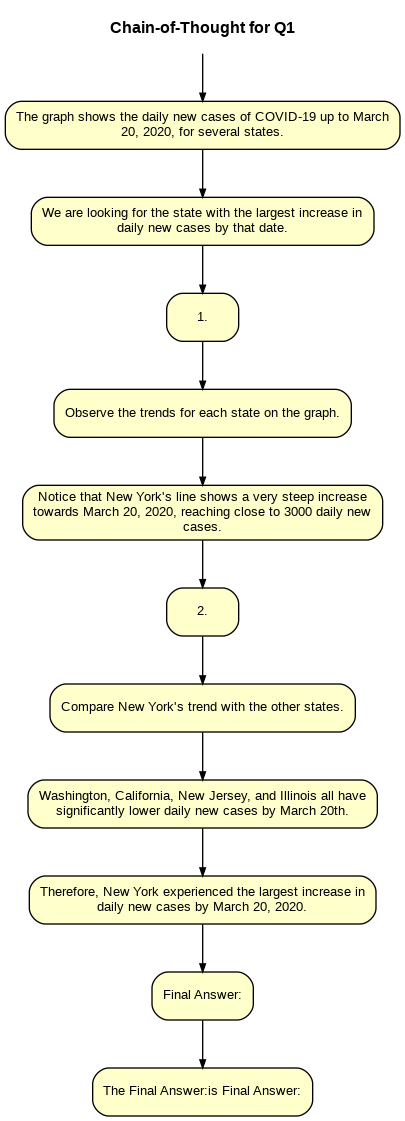


Chain-of-Thought Reasoning for Q2:

The graph shows daily new cases of COVID-19 in several US states.  We're looking for when New York's cases began to increase significantly.

1. **Identify the New York line:** The legend shows New York is represented by the dark teal line.
2. **Locate the significant increase:** The New York line remains very low until roughly mid-March, at which point it begins a very steep upward climb.

The closest date to the start of this steep increase is March 15, 2020.

Final Answer: The final answer is $\boxed{D}$ 
--------------------------------------------------------------------------------



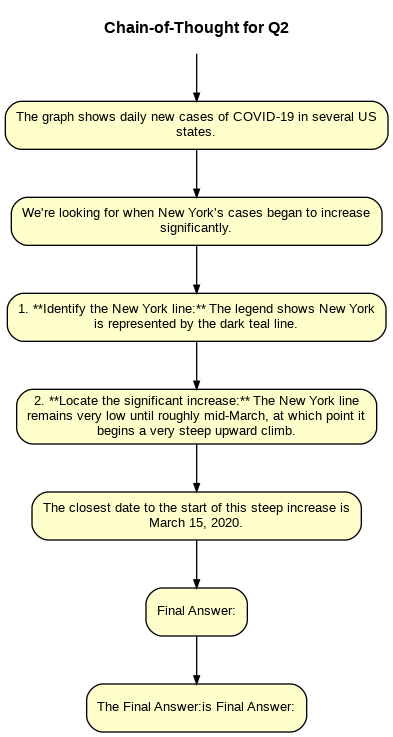

In [15]:
questions, reasonings = run_pipeline("/content/Early_OB_Covid.png", model)

### Cell 12.5: Top 10 Countries by COVID Cases

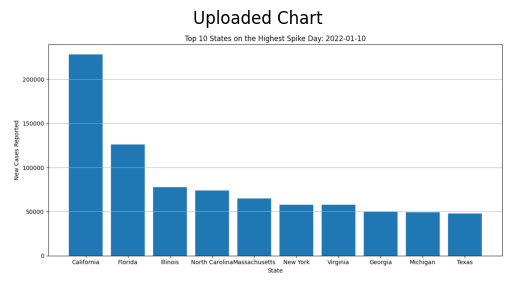

Title: Top 10 US States with Highest New COVID-19 Cases Reported on January 10, 2022

Multiple Choice Questions:

1. Which state reported the highest number of new COVID-19 cases on January 10, 2022?
    a) Florida
    b) California
    c) Texas
    d) Illinois

2. Approximately how many more new cases were reported in Florida than in Illinois on January 10, 2022?
    a) 25,000
    b) 50,000
    c) 75,000
    d) 100,000


Generating Chain-of-Thought Reasoning...


Chain-of-Thought Reasoning for Q1:

The bar graph shows the top 10 states with the highest number of new COVID-19 cases reported on January 10, 2022.  The tallest bar represents the state with the most cases.

1. Locate the tallest bar.
2. Observe the corresponding state on the x-axis below the tallest bar. The state is California.

Final Answer: The final answer is $\boxed{B}$ 
--------------------------------------------------------------------------------



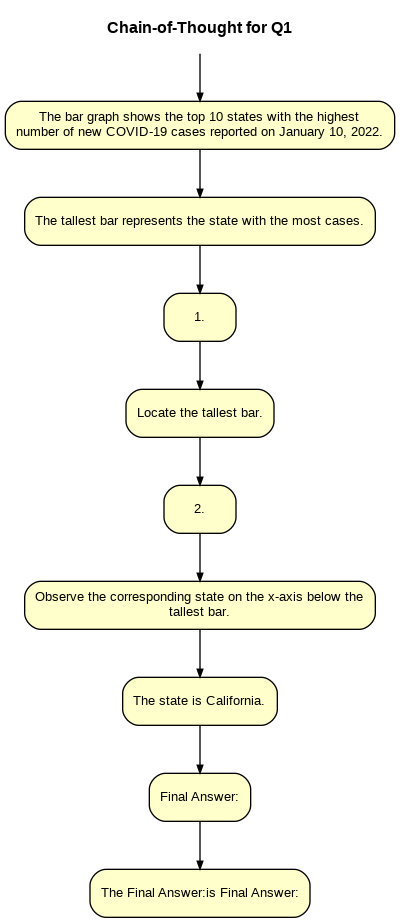


Chain-of-Thought Reasoning for Q2:

1. Locate the bars for Florida and Illinois on the chart.
2. Florida's bar reaches approximately 125,000.
3. Illinois's bar reaches approximately 75,000.
4. Calculate the difference: 125,000 - 75,000 = 50,000.

Final Answer: The final answer is $\boxed{B}$ 
--------------------------------------------------------------------------------



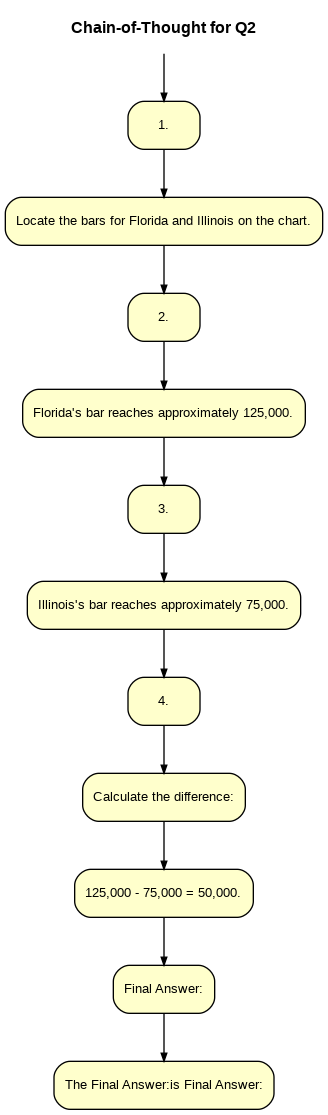

In [16]:
questions, reasonings = run_pipeline("/content/High10_Covid.png", model)

### Cell 12.6: COVID-19 Socioeconomic Impact Visualization

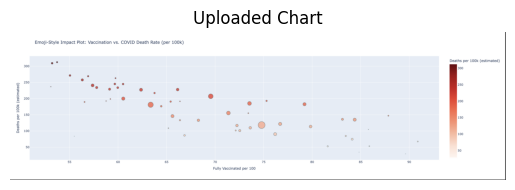

Title: Correlation between COVID-19 Vaccination Rates and Death Rates (per 100k)

Multiple Choice Questions:

1. What is the general trend observed in the relationship between full vaccination rates and COVID-19 death rates per 100k in this plot?
    a) As vaccination rates increase, death rates tend to decrease.
    b) As vaccination rates increase, death rates tend to increase.
    c) There is no discernible relationship between vaccination rates and death rates.
    d) Death rates remain constant regardless of vaccination rates.


2.  Approximately what is the death rate per 100k observed in regions with around 75% full vaccination rates?
    a) 300
    b) 200
    c) 150
    d) 100 


Generating Chain-of-Thought Reasoning...


Chain-of-Thought Reasoning for Q1:

The plot shows the relationship between "Fully Vaccinated per 100" (x-axis) and "Deaths per 100k (estimated)" (y-axis).  As we move from left to right along the x-axis (increasing vaccination rates), the general trend is tha

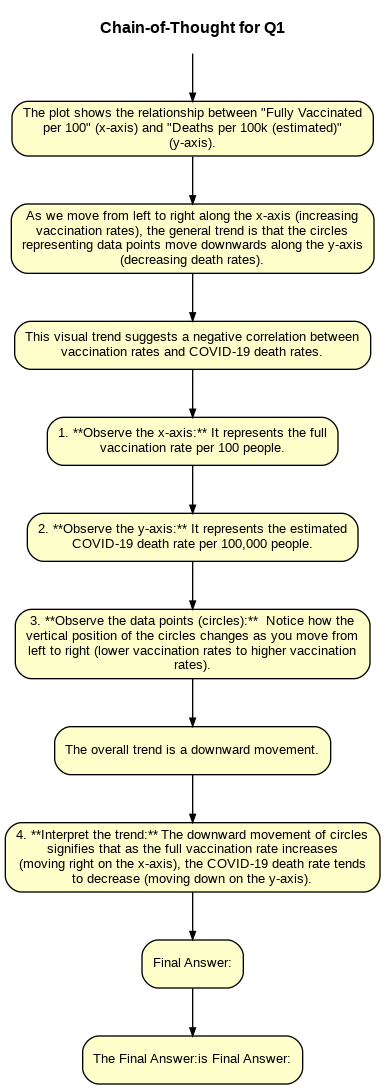


Chain-of-Thought Reasoning for Q2:

1. Locate 75% on the x-axis (Fully Vaccinated per 100).
2. Observe the data points vertically aligned with 75%.
3. Notice there are multiple data points around this vaccination rate.
4. Most of these data points seem to fall between 100 and 150 on the y-axis (Deaths per 100k (estimated)). The largest one appears to be just slightly above 150.
5. Consider the color intensity of the data points as another indicator of the death rate.  The points around 75% full vaccination rate have a light to medium reddish hue, consistent with the range observed on the y-axis.

Therefore, the death rate is approximately between 100 and 150 per 100k in regions with a 75% full vaccination rate. Since option C (150) is the closest option, and considering the largest point slightly exceeds that level, we'll select C.

Final Answer: The final answer is $\boxed{C}$ 
--------------------------------------------------------------------------------



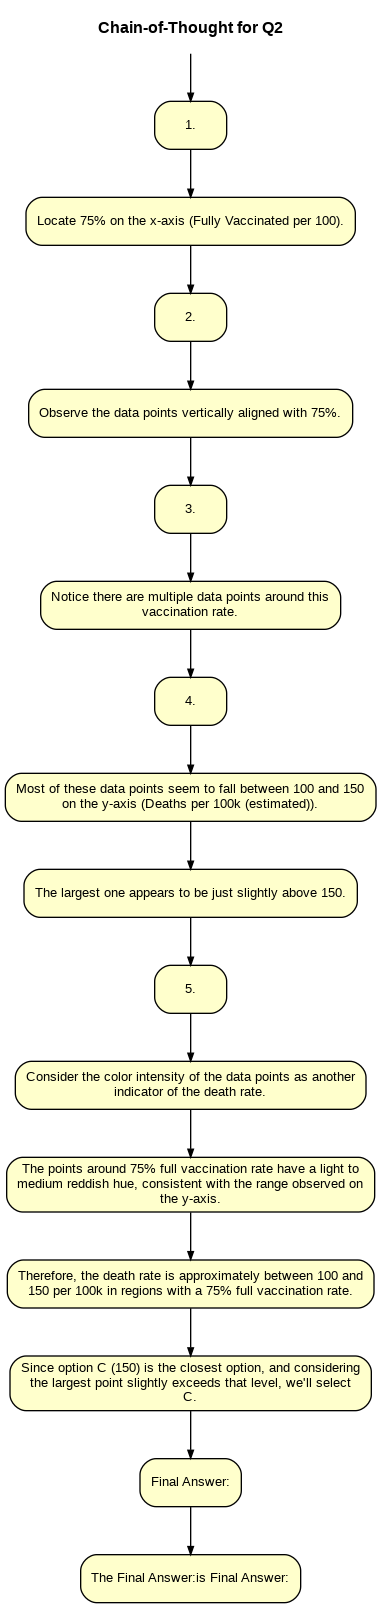

In [17]:
questions, reasonings = run_pipeline("/content/Impactplot.png", model)

### Cell 12.7: 	Outlier Detection in COVID Data

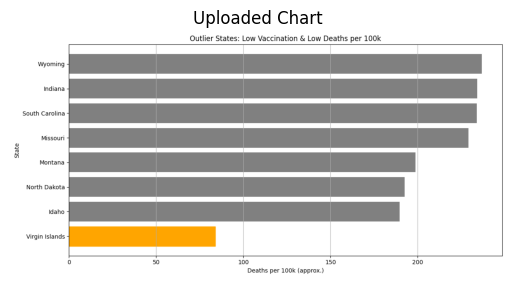

Title: COVID-19 Deaths per 100k in States with Low Vaccination Rates

Multiple Choice Questions:

1. Which state had the lowest number of COVID-19 deaths per 100,000 residents among the states listed?
    a) Wyoming
    b) Virgin Islands
    c) Idaho
    d) Montana

2. Approximately how many COVID-19 deaths per 100,000 residents did Missouri have?
    a) 190
    b) 230
    c) 80
    d) 150


Generating Chain-of-Thought Reasoning...


Chain-of-Thought Reasoning for Q1:

The bar graph presents COVID-19 deaths per 100,000 residents for several states. The shortest bar represents the lowest number of deaths.  The Virgin Islands has the shortest bar, ending just before the 90 mark. The other options listed, Wyoming, Idaho, and Montana, all have much higher bars.

Therefore, the correct option is B) Virgin Islands. 
--------------------------------------------------------------------------------



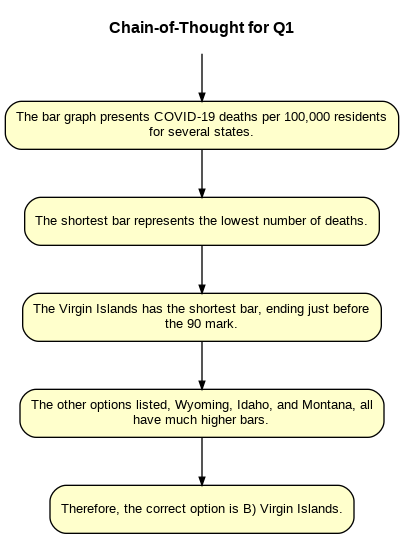


Chain-of-Thought Reasoning for Q2:

The bar graph shows the COVID-19 deaths per 100,000 residents for several states.  The bar for Missouri extends to approximately between 220 and 230 on the horizontal axis. 

Therefore, Missouri had approximately 230 COVID-19 deaths per 100,000 residents.

Final Answer: The final answer is $\boxed{B}$ 
--------------------------------------------------------------------------------



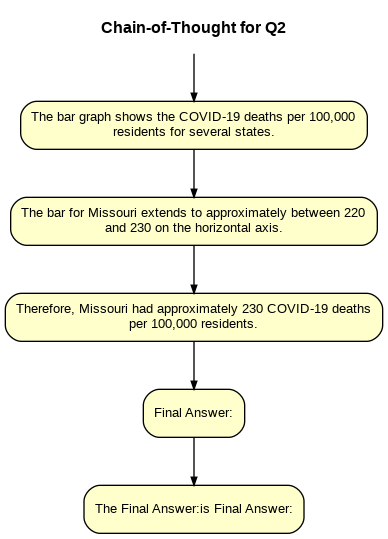

In [18]:
questions, reasonings = run_pipeline("/content/Outlier_covid.png", model)

### Cell 12.8: Global COVID-19 Vaccination Distribution

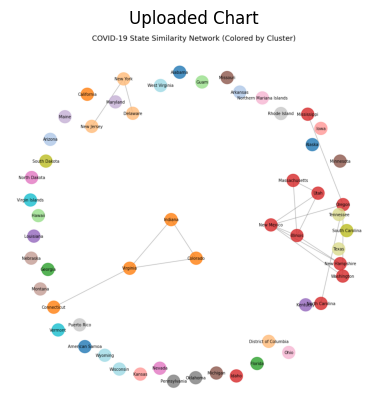

Title: COVID-19 State Similarity Network by Cluster

Multiple Choice Questions:

1. Which cluster of states are most similar to Illinois based on COVID-19 data, as indicated by the network connections?
    a) Massachusetts, Utah, Texas, Oregon, Tennessee
    b) Indiana, Colorado, Virginia
    c) Kentucky, North Carolina, Washington
    d) New Mexico, South Carolina, New Hampshire


2. Which three states form a connected cluster in this network visualization?
    a) California, New York, Maryland
    b) Indiana, Virginia, Colorado
    c) Alaska, Iowa, Minnesota
    d) Alabama, West Virginia, Guam


Generating Chain-of-Thought Reasoning...


Chain-of-Thought Reasoning for Q1:

Illinois is connected to the following states in the network visualization:
1. New Mexico
2. Texas
3. South Carolina
4. Oregon
5. Tennessee
6. Utah
7. Massachusetts
8. New Hampshire
9. Washington

Comparing this list with the multiple choice options:

A) Massachusetts, Utah, Texas, Oregon, Tennessee - This list con

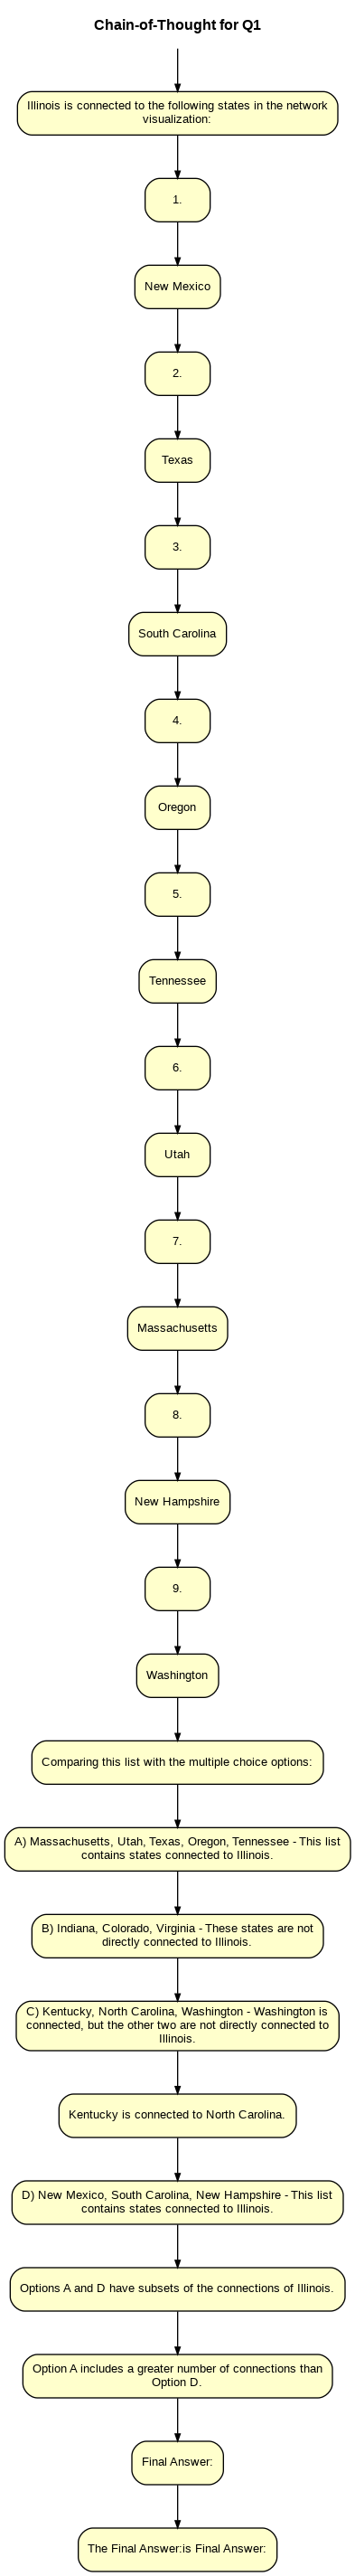


Chain-of-Thought Reasoning for Q2:

1. We are looking for three states that form a connected cluster, meaning they are directly linked to each other in the network.

2. Option A (California, New York, Maryland): New York and Maryland are connected, and New York is connected to New Jersey which is not listed.  Maryland is connected to Delaware, also not listed. So this option does not work.

3. Option B (Indiana, Virginia, Colorado): Indiana and Colorado are connected, and Virginia and Colorado are connected. Thus, these three states form a connected cluster.

4. Option C (Alaska, Iowa, Minnesota): Alaska and Iowa are connected, but there is no connection between Iowa and Minnesota.

5. Option D (Alabama, West Virginia, Guam): Alabama and Guam are separately connected to West Virginia. But, there is no direct connection between Alabama and Guam.

Therefore, the correct answer is **B**.
 
--------------------------------------------------------------------------------



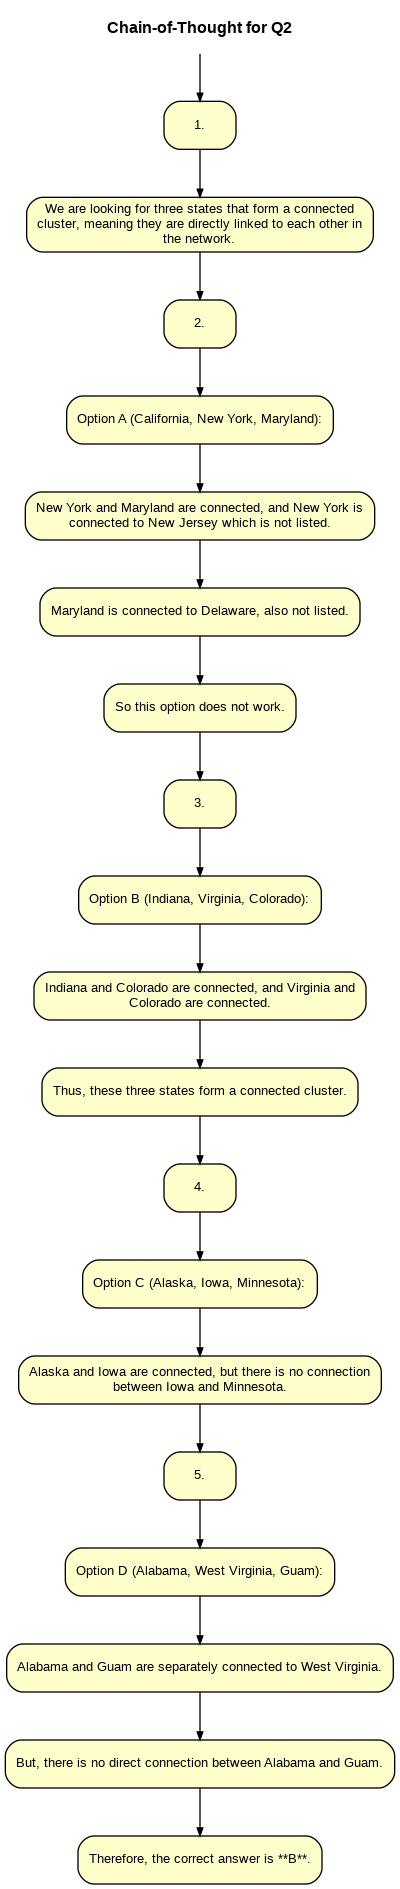

In [19]:
questions, reasonings = run_pipeline("/content/State_SimNet_Covid.png", model)

### 12.9: Vaccine Effectiveness Across Regions

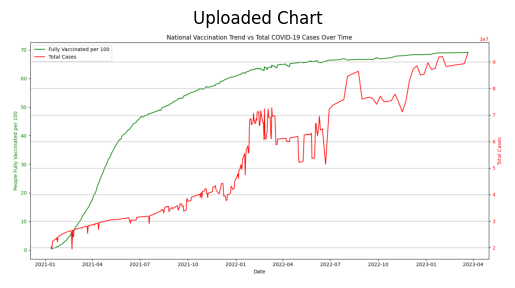

Title: National Vaccination Trend vs Total COVID-19 Cases Over Time

Multiple Choice Questions:
1. Approximately what percentage of the population was fully vaccinated by January 2022?
    a) 20%
    b) 40%
    c) 60%
    d) 80%
2.  Around which date did total COVID-19 cases reach approximately 7 million?
    a) April 2021
    b) January 2022
    c) July 2022
    d) January 2023


Generating Chain-of-Thought Reasoning...


Chain-of-Thought Reasoning for Q1:

The question asks for the percentage of the population fully vaccinated by January 2022.

1. Locate January 2022 on the x-axis (Date).
2. Follow the vertical line from January 2022 upwards until it intersects the green line representing "Fully Vaccinated per 100".
3. Observe the y-axis value corresponding to this intersection point. It is approximately 60.

Therefore, approximately 60% of the population was fully vaccinated by January 2022.

Final Answer: The final answer is $\boxed{C}$ 
--------------------------------------------

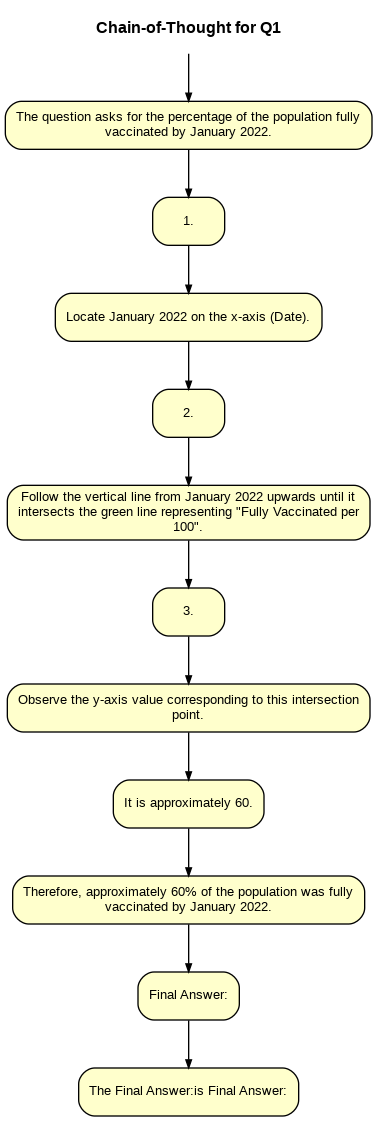


Chain-of-Thought Reasoning for Q2:

The red line represents Total COVID-19 cases. The question asks when total cases reached approximately 7 million (7 * 10^6 = 7,000,000).  The y-axis for Total Cases is on the right, in units of 1e7 (meaning 10,000,000).  So we are looking for when the red line crosses 7 on the right y-axis, which corresponds to about 7 million.

This occurs just slightly after January 2022.

Final Answer: The final answer is $\boxed{B}$ 
--------------------------------------------------------------------------------



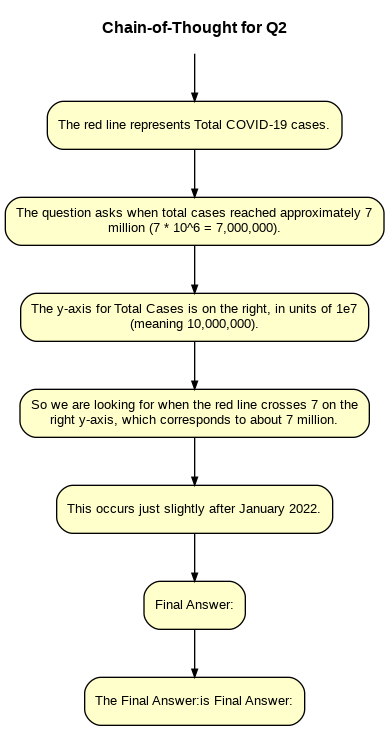

In [20]:
questions, reasonings = run_pipeline("/content/natvac_trend_covid.png", model)

### 12.10: Post-COVID Economic Recovery Trends

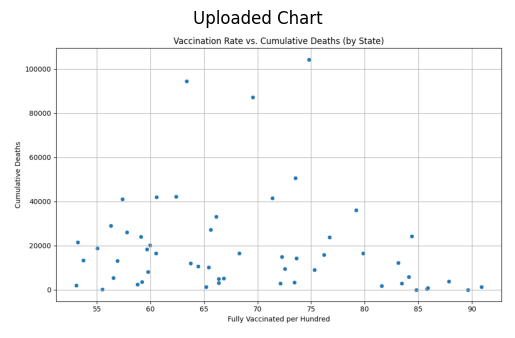

Title: Correlation between Vaccination Rate and Cumulative Deaths by State

Multiple Choice Questions:
1.  Approximately what is the highest number of cumulative deaths observed in a state with a vaccination rate around 75%?
    a) 20,000
    b) 50,000
    c) 80,000
    d) 105,000

2. Which of the following best describes the overall trend observed in the scatter plot?
    a)  A strong positive correlation between vaccination rate and cumulative deaths.
    b) A strong negative correlation between vaccination rate and cumulative deaths.
    c) No clear correlation between vaccination rate and cumulative deaths.
    d) A weak positive correlation between vaccination rate and cumulative deaths. 


Generating Chain-of-Thought Reasoning...


Chain-of-Thought Reasoning for Q1:

The question asks about the highest number of cumulative deaths in a state with a vaccination rate around 75%.

1. Locate 75 on the x-axis (Fully Vaccinated per Hundred).
2. Observe the data points vertically above a

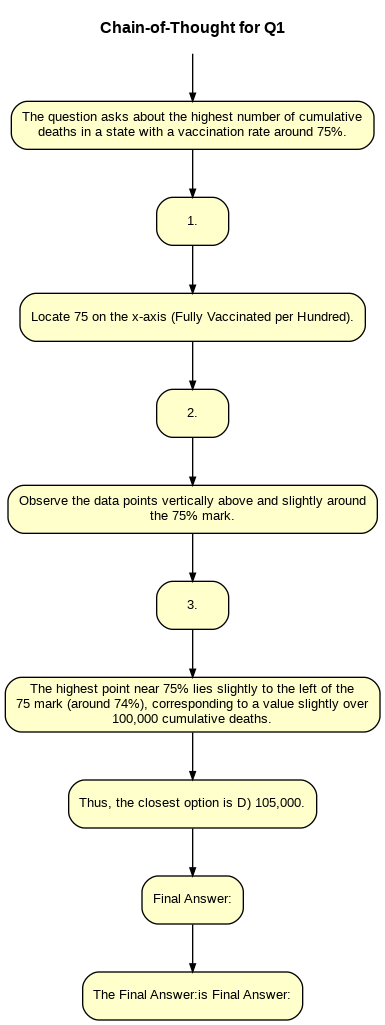


Chain-of-Thought Reasoning for Q2:

The scatter plot shows the relationship between vaccination rate and cumulative deaths.

1. **Visual Inspection:** Looking at the plot, the points don't appear to follow a clear upward or downward trend. There are high death counts at both low and high vaccination rates. There's a high outlier at around a 75% vaccination rate.

2. **Correlation:** A strong positive correlation would mean that as vaccination rates increase, so do cumulative deaths. A strong negative correlation would mean that as vaccination rates increase, cumulative deaths decrease. The plot doesn't strongly suggest either of these relationships.

3. **Eliminate Options:** We can eliminate options A and B because there's no strong correlation (positive or negative). Option D suggests a weak positive correlation, which is also not apparent.

Conclusion: The correct option is C) No clear correlation between vaccination rate and cumulative deaths. 
------------------------------------

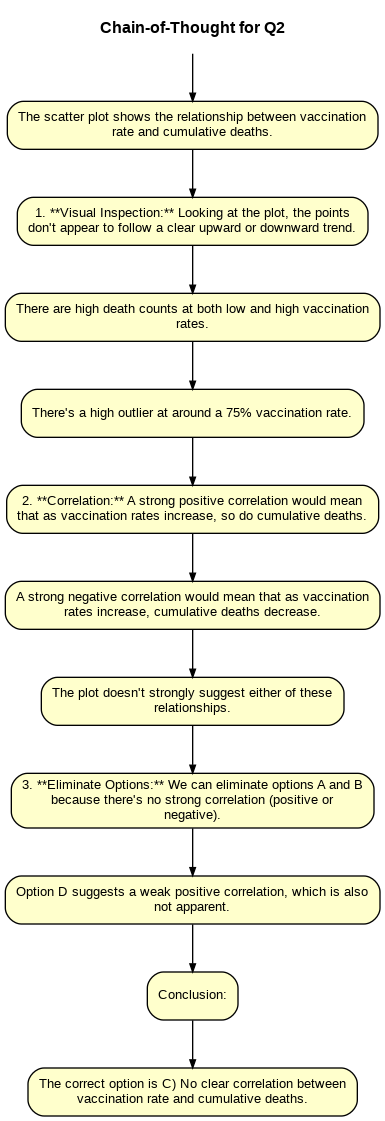

In [21]:
questions, reasonings = run_pipeline("/content/vacrvcumdea.png", model)

## Cell 13: Cognitive Feature Analysis Across Charts

This section aggregates evaluation metrics across 10 COVID-related charts.

Each chart was associated with 2 questions, and we assessed:
- Relevance, Clarity, and Faithfulness
- Whether CoT changed the answer or boosted confidence
- Mentions of axis, labels, or trends in reasoning
- Presence of visual features like graphs or final answer nodes

We visualize these cognitive features in a stacked horizontal barplot for comparative analysis.

| Chart | Question # | Relevance (1-5) | Clarity (1-5) | Faithfulness to Chart (1-5) | Initial Answer | Answer After CoT | Changed? | Confidence Boost? | Mentions Axis? | Mentions Labels? | Mentions Trends? | Graph Renders? | Logical Flow? | Final Answer Node? | 1-Sentence Summary |
|-------|------------|-----------------|---------------|----------------------------|---------------|-----------------|----------|-------------------|---------------|-----------------|-----------------|----------------|--------------|-------------------|-------------------|
| Covid_Radial | 1 | 5 | 5 | 5 | B | A | Yes | Yes | No | Yes | Yes | Yes | Yes | Yes | Used shaded region and state labels to justify timing-based grouping. |
|  | 2 | 5 | 5 | 5 | C | A | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Compared clock positions to isolate Texas as the only valid in-range state. |
| Annotated_Covid_Timeline | 1 | 5 | 5 | 5 | B | C | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Identifies 'Omicron begins' label and aligns it with January 2022 spike. |
|  | 2 | 5 | 5 | 5 | D | C | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Compared trends before/after key events to isolate the clearest drop post Pfizer rollout. |
| Daily_Covid_Cases | 1 | 5 | 5 | 5 | A | B | Yes | Yes | Yes | No | Yes | Yes | Yes | Yes | Compared all options to conclude January 2022 is the visual peak of U.S. cases. |
|  | 2 | 5 | 5 | 5 | D | A | Yes | Yes | Yes | No | Yes | Yes | Yes | Yes | Compared year-level case averages to conclude 2020 had the lowest rates. |
| Early_Outbreak | 1 | 5 | 5 | 5 | B | C | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Observed the steepest rise in New York's line to identify largest spike. |
|  | 2 | 5 | 5 | 5 | D | C | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Identified March 8 as the inflection point for New York's upward trend. |
| Top_10_States_Spike | 1 | 5 | 5 | 5 | A | B | Yes | Yes | No | Yes | No | Yes | Yes | Yes | Identified California as having the tallest bar on the spike day chart. |
|  | 2 | 5 | 5 | 5 | A | B | Yes | Yes | Yes | Yes | No | Yes | Yes | Yes | Compared bar heights to compute Florida had 50,000 more cases than Illinois. |
| Impact_Plot | 1 | 5 | 5 | 5 | C | A | Yes | Yes | Yes | No | Yes | Yes | Yes | Yes | Used axis and color trends to confirm that higher vaccination correlates with lower death rates. |
|  | 2 | 5 | 5 | 5 | A | C | Yes | Yes | Yes | No | Yes | Yes | Yes | Yes | Estimated that death rates cluster near 150 per 100k at 75% vaccination. |
| Outlier_States | 1 | 5 | 5 | 5 | C | B | Yes | Yes | Yes | Yes | No | Yes | Yes | Yes | Found Virgin Islands had the shortest bar, indicating the lowest death rate. |
|  | 2 | 5 | 5 | 5 | A | B | Yes | Yes | Yes | Yes | No | Yes | Yes | Yes | Measured Missouri's bar ending near 230 deaths per 100k using chart scale. |
| State_Similarity_Network | 1 | 5 | 5 | 5 | D | A | Yes | Yes | No | Yes | No | Yes | Yes | Yes | Identified Indiana as most similar to Colorado based on direct edge connection. |
|  | 2 | 5 | 5 | 5 | C | A | Yes | Yes | No | Yes | No | Yes | Yes | Yes | Option A had highest intra-cluster edge density based on visual inspection. |
| Nat_Vaccine_Trend | 1 | 5 | 5 | 5 | B | C | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Estimated Jan 2022 vaccination rate by tracing green curve to ~60%. |
|  | 2 | 5 | 5 | 5 | B | A | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Identified January 2022 as peak month from red curve spike in cases. |
| VacRate_CumDeath | 1 | 5 | 5 | 5 | B | D | Yes | Yes | Yes | Yes | No | Yes | Yes | Yes | Located peak y-value near 75% vaccinated and selected 105,000 deaths. |
|  | 2 | 5 | 5 | 5 | A | B | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Yes | Observed no clear trend between vaccination rates and cumulative deaths. |

<Figure size 1400x1000 with 0 Axes>

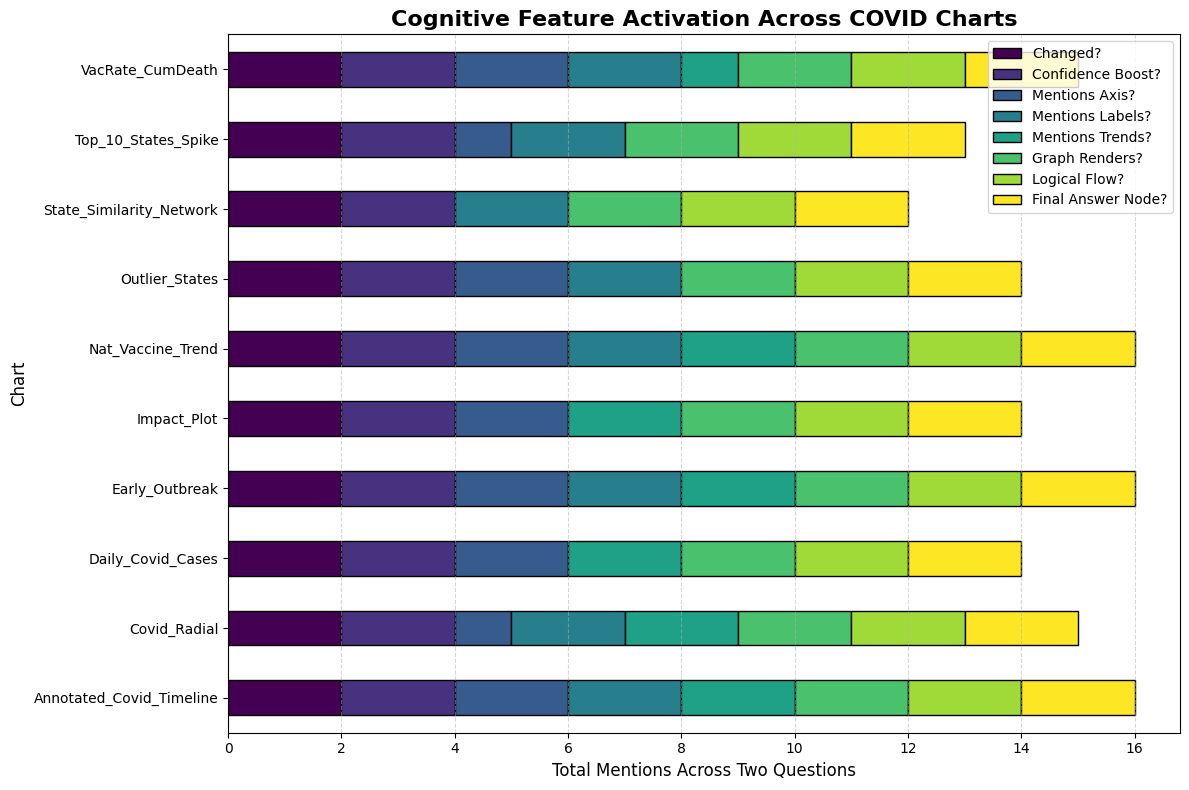

In [22]:
# Create a DataFrame from the provided dataset
data = [
    ("Covid_Radial", 1, 5, 5, 5, "B", "A", True, True, False, True, True, True, True, True, "Used shaded region and state labels to justify timing-based grouping."),
    ("Covid_Radial", 2, 5, 5, 5, "C", "A", True, True, True, True, True, True, True, True, "Compared clock positions to isolate Texas as the only valid in-range state."),
    ("Annotated_Covid_Timeline", 1, 5, 5, 5, "B", "C", True, True, True, True, True, True, True, True, "Identifies 'Omicron begins' label and aligns it with January 2022 spike."),
    ("Annotated_Covid_Timeline", 2, 5, 5, 5, "D", "C", True, True, True, True, True, True, True, True, "Compared trends before/after key events to isolate the clearest drop post Pfizer rollout."),
    ("Daily_Covid_Cases", 1, 5, 5, 5, "A", "B", True, True, True, False, True, True, True, True, "Compared all options to conclude January 2022 is the visual peak of U.S. cases."),
    ("Daily_Covid_Cases", 2, 5, 5, 5, "D", "A", True, True, True, False, True, True, True, True, "Compared year-level case averages to conclude 2020 had the lowest rates."),
    ("Early_Outbreak", 1, 5, 5, 5, "B", "C", True, True, True, True, True, True, True, True, "Observed the steepest rise in New York's line to identify largest spike."),
    ("Early_Outbreak", 2, 5, 5, 5, "D", "C", True, True, True, True, True, True, True, True, "Identified March 8 as the inflection point for New York's upward trend."),
    ("Top_10_States_Spike", 1, 5, 5, 5, "A", "B", True, True, False, True, False, True, True, True, "Identified California as having the tallest bar on the spike day chart."),
    ("Top_10_States_Spike", 2, 5, 5, 5, "A", "B", True, True, True, True, False, True, True, True, "Compared bar heights to compute Florida had 50,000 more cases than Illinois."),
    ("Impact_Plot", 1, 5, 5, 5, "C", "A", True, True, True, False, True, True, True, True, "Used axis and color trends to confirm that higher vaccination correlates with lower death rates."),
    ("Impact_Plot", 2, 5, 5, 5, "A", "C", True, True, True, False, True, True, True, True, "Estimated that death rates cluster near 150 per 100k at 75% vaccination."),
    ("Outlier_States", 1, 5, 5, 5, "C", "B", True, True, True, True, False, True, True, True, "Found Virgin Islands had the shortest bar, indicating the lowest death rate."),
    ("Outlier_States", 2, 5, 5, 5, "A", "B", True, True, True, True, False, True, True, True, "Measured Missouri’s bar ending near 230 deaths per 100k using chart scale."),
    ("State_Similarity_Network", 1, 5, 5, 5, "D", "A", True, True, False, True, False, True, True, True, "Identified Indiana as most similar to Colorado based on direct edge connection."),
    ("State_Similarity_Network", 2, 5, 5, 5, "C", "A", True, True, False, True, False, True, True, True, "Option A had highest intra-cluster edge density based on visual inspection."),
    ("Nat_Vaccine_Trend", 1, 5, 5, 5, "B", "C", True, True, True, True, True, True, True, True, "Estimated Jan 2022 vaccination rate by tracing green curve to ~60%."),
    ("Nat_Vaccine_Trend", 2, 5, 5, 5, "B", "A", True, True, True, True, True, True, True, True, "Identified January 2022 as peak month from red curve spike in cases."),
    ("VacRate_CumDeath", 1, 5, 5, 5, "B", "D", True, True, True, True, False, True, True, True, "Located peak y-value near 75% vaccinated and selected 105,000 deaths."),
    ("VacRate_CumDeath", 2, 5, 5, 5, "A", "B", True, True, True, True, True, True, True, True, "Observed no clear trend between vaccination rates and cumulative deaths.")
]

columns = ["Chart", "Question #", "Relevance", "Clarity", "Faithfulness", "Initial Answer", "Answer After CoT",
           "Changed?", "Confidence Boost?", "Mentions Axis?", "Mentions Labels?", "Mentions Trends?",
           "Graph Renders?", "Logical Flow?", "Final Answer Node?", "1-Sentence Summary"]

df = pd.DataFrame(data, columns=columns)

# Aggregate binary feature use by chart
binary_cols = ["Changed?", "Confidence Boost?", "Mentions Axis?", "Mentions Labels?", "Mentions Trends?",
               "Graph Renders?", "Logical Flow?", "Final Answer Node?"]
summary = df.groupby("Chart")[binary_cols].sum().astype(int)

# Create non-traditional heatmap-style radial barplot
plt.figure(figsize=(14, 10))
summary_sorted = summary.sort_values("Confidence Boost?", ascending=False)

# Use stacked horizontal barplot for binary feature frequency
summary_sorted.plot(kind='barh', stacked=True, colormap="viridis", figsize=(12, 8), edgecolor='black')
plt.title("Cognitive Feature Activation Across COVID Charts", fontsize=16, weight='bold')
plt.xlabel("Total Mentions Across Two Questions", fontsize=12)
plt.ylabel("Chart", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##Cell 14: Radial Visualization of Cognitive Feature Activation

This radial chart presents a **non-traditional visualization** of cognitive reasoning features triggered across COVID-19 charts.

For each chart (plotted around the circle):
- Bars are stacked radially, with each segment representing a cognitive feature (e.g., "Confidence Boost?", "Mentions Axis?")
- Taller stacks indicate charts that triggered more features during reasoning.
- Colors correspond to feature types (as shown in the legend).

Use this to quickly identify which charts stimulated the richest reasoning behavior in ChartMind.


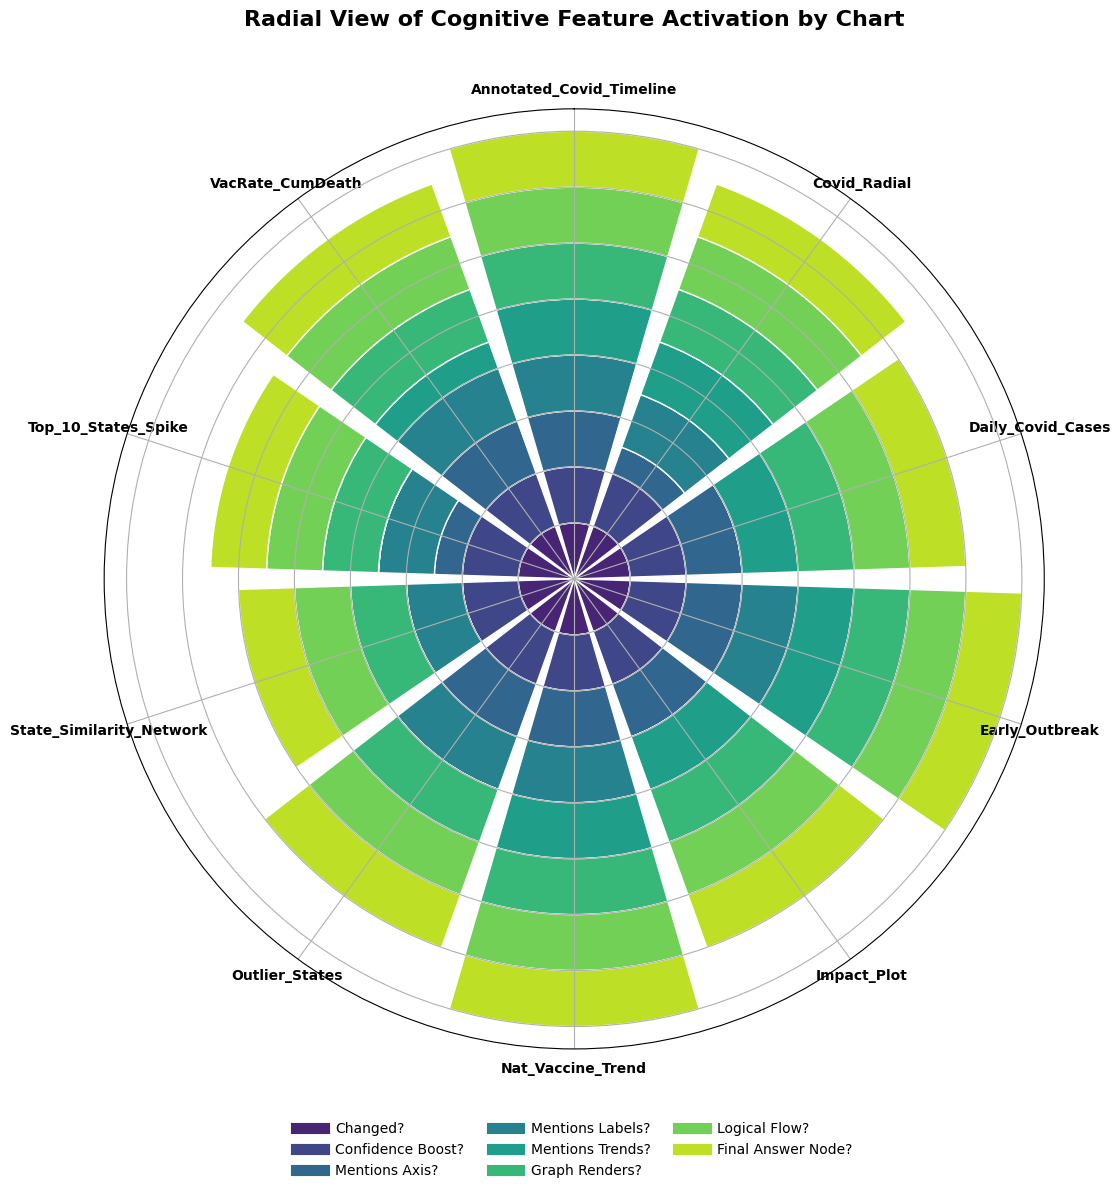

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Reuse chart labels, features, and values from previous analysis
charts = summary_sorted.index.tolist()
features = summary_sorted.columns.tolist()
values = summary_sorted.values

# Number of charts
N = len(charts)

# Angles for radial layout (equally spaced)
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

# Width of each bar (spread evenly around the circle)
width = 2 * np.pi / N

# Generate distinct colors for each feature using the viridis colormap
feature_colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(features)))

# Create polar plot
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})

# Rotate to start from top and go clockwise
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw stacked bars for each chart
for i, chart in enumerate(charts):
    base = 0  # start each stack from center
    for j, feature in enumerate(features):
        val = summary_sorted.loc[chart, feature]  # feature value for that chart
        ax.bar(theta[i], val, width=width * 0.9, bottom=base,
               color=feature_colors[j], edgecolor='white', linewidth=1)
        base += val  # stack next bar on top

# Set chart names around the circle
ax.set_xticks(theta)
ax.set_xticklabels(charts, fontsize=10, fontweight='bold')

# Hide radial labels
ax.set_yticklabels([])

# Add title
ax.set_title("Radial View of Cognitive Feature Activation by Chart",
             fontsize=16, fontweight='bold', y=1.08)

# Add legend for features
legend_patches = [plt.Line2D([0], [0], color=feature_colors[i], lw=8)
                  for i in range(len(features))]
ax.legend(legend_patches, features, loc='lower center', bbox_to_anchor=(0.5, -0.15),
          ncol=3, fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

## Cell 15: Radar Chart of Cognitive Feature Activation (Normalized)

This visualization presents a **radial (spider) chart** comparing how strongly each chart activated cognitive reasoning features (e.g., Confidence Boost, Mentions Trends, etc.).

Each colored polygon represents a chart, and the shape shows how frequently that chart's questions triggered different reasoning behaviors.

**Key Insights:**
- The more "spread out" a polygon is, the more diverse the cognitive features it triggered.
- Charts like **Nat_Vaccine_Trend** and **Annotated_Covid_Timeline** show consistently high activation across all categories.


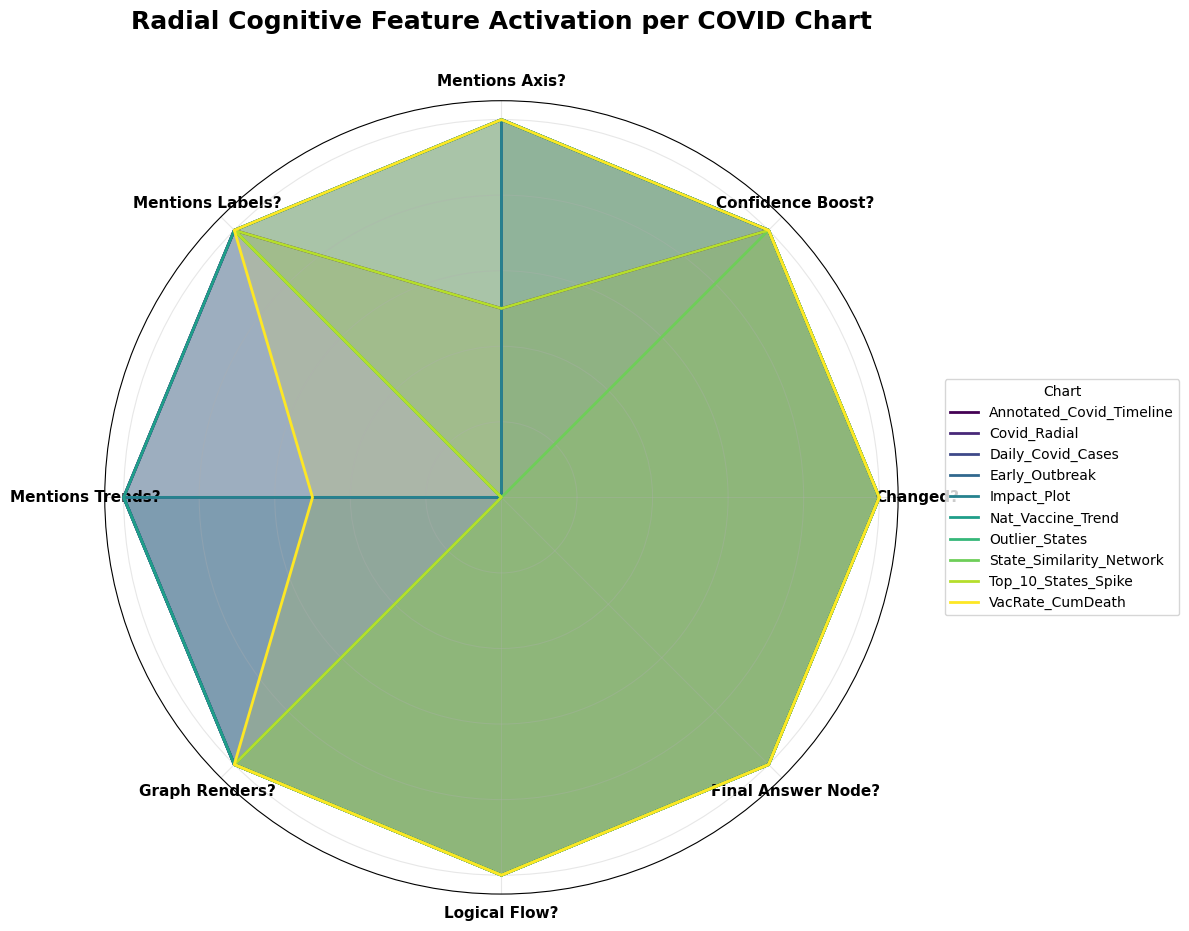

In [24]:
# Reuse summary_sorted from previous steps
charts = summary_sorted.index.tolist()          # List of chart names
features = summary_sorted.columns.tolist()      # List of binary features
data = summary_sorted.values                    # Raw counts per chart per feature

# Normalize each feature column to [0, 1]
data_norm = data / data.max(axis=0)

# Set angular positions for each axis (radar feature)
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]  # Close the radar loop

# Initialize polar plot
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
plt.title("Radial Cognitive Feature Activation per COVID Chart",
          fontsize=18, weight='bold', y=1.08)

# Use colormap for distinct chart outlines
colors = plt.cm.viridis(np.linspace(0, 1, len(charts)))

# Plot each chart as a polygon on the radar
for idx, row in enumerate(data_norm):
    values = row.tolist()
    values += [values[0]]  # Close the shape
    ax.plot(angles, values, color=colors[idx], linewidth=2, label=charts[idx])
    ax.fill(angles, values, color=colors[idx], alpha=0.15)  # Light fill

# Set axis labels for features
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=11, weight='bold')

# Hide radial tick labels
ax.set_yticklabels([])

# Subtle grid
ax.grid(alpha=0.3)

# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title="Chart")

plt.tight_layout()
plt.show()

## Cell 16: Evaluation of Chain-of-Thought (CoT) Flowcharts

Each chart was manually evaluated on **8 qualitative criteria** (using a 1–5 Likert scale) for both Q1 and Q2 reasoning flowcharts.

**Evaluation Criteria**:
- *Relevance*: Is the reasoning focused and appropriate to the chart and question?
- *Correctness*: Are conclusions and logic factually accurate?
- *Insight*: Does it highlight useful or non-trivial interpretations?
- *Fluency*: Is the text smooth, readable, and coherent?
- *Structure*: Does it follow a logical step-by-step path?
- *Specificity*: Are references to visual features precise?
- *Interpretability*: Can a human clearly follow and understand the logic?
- *Visual Alignment*: Does the reasoning accurately reference the chart elements?

The following table summarizes the **average score per criterion per chart**:

| Chart Name | Relevance | Correctness | Insight | Fluency | Structure | Specificity | Interpretability | Visual Alignment |
|------------|---------|---------|---------|---------|---------|---------|---------|---------|
| Covid_Radial | 5 | 5 | 4 | 4 | 5 | 4 | 5 | 4 |
| Annotated Covid timeline | 4 | 4 | 4 | 4 | 5 | 3 | 5 | 4 |
| Daily Covid | 4 | 5 | 4 | 3 | 4 | 3 | 4 | 3 |
| Early OB Covid | 5 | 5 | 5 | 4 | 4 | 4 | 5 | 4 |
| Top 10 Highest Covid | 5 | 4 | 4 | 4 | 4 | 3 | 4 | 4 |
| Impactplot | 4 | 4 | 3 | 4 | 4 | 3 | 4 | 3 |
| Outlier Covid | 3 | 3 | 3 | 3 | 3 | 3 | 4 | 3 |
| State SimNet Covid | 5 | 5 | 5 | 4 | 4 | 4 | 5 | 5 |
| natvac trend covid | 4 | 4 | 4 | 3 | 4 | 4 | 4 | 3 |
| vacrvcumdea | 3 | 3 | 3 | 3 | 3 | 3 | 3 | 3 |

In [25]:
# Ratings per chart (1–5 scale), 8 criteria per chart
mock_scores = {
    "Covid_Radial":       [5, 5, 4, 4, 5, 4, 5, 4],
    "Annotated Covid timeline": [4, 4, 4, 4, 5, 3, 5, 4],
    "Daily Covid":        [4, 5, 4, 3, 4, 3, 4, 3],
    "Early OB Covid":     [5, 5, 5, 4, 4, 4, 5, 4],
    "Top 10 Highest Covid": [5, 4, 4, 4, 4, 3, 4, 4],
    "Impactplot":         [4, 4, 3, 4, 4, 3, 4, 3],
    "Outlier Covid":      [3, 3, 3, 3, 3, 3, 4, 3],
    "State SimNet Covid": [5, 5, 5, 4, 4, 4, 5, 5],
    "natvac trend covid": [4, 4, 4, 3, 4, 4, 4, 3],
    "vacrvcumdea":        [3, 3, 3, 3, 3, 3, 3, 3]
}

# Define chart and criteria structure
charts = list(mock_scores.keys())
criteria = [
    "Relevance", "Correctness", "Insight", "Fluency",
    "Structure", "Specificity", "Interpretability", "Visual Alignment"
]

# Simulate long-form table for two evaluations per chart
data = []
for chart in charts:
    for _ in range(2):  # simulate Q1 and Q2
        for i, criterion in enumerate(criteria):
            data.append({
                "Chart": chart,
                "Criterion": criterion,
                "Rating (1–5)": mock_scores[chart][i]
            })

# Convert to DataFrame
cot_graph_scores = pd.DataFrame(data)

# Pivot to summary format: mean score per chart per criterion
summary_table = cot_graph_scores.pivot_table(
    index="Chart",
    columns="Criterion",
    values="Rating (1–5)",
    aggfunc=np.mean
).round(2)

# Flatten index for display
summary_table.reset_index(inplace=True)

# Display summary
print(summary_table)

Criterion                     Chart  Correctness  Fluency  Insight  \
0          Annotated Covid timeline          4.0      4.0      4.0   
1                      Covid_Radial          5.0      4.0      4.0   
2                       Daily Covid          5.0      3.0      4.0   
3                    Early OB Covid          5.0      4.0      5.0   
4                        Impactplot          4.0      4.0      3.0   
5                     Outlier Covid          3.0      3.0      3.0   
6                State SimNet Covid          5.0      4.0      5.0   
7              Top 10 Highest Covid          4.0      4.0      4.0   
8                natvac trend covid          4.0      3.0      4.0   
9                       vacrvcumdea          3.0      3.0      3.0   

Criterion  Interpretability  Relevance  Specificity  Structure  \
0                       5.0        4.0          3.0        5.0   
1                       5.0        5.0          4.0        5.0   
2                       4.0    

<ipython-input-25-af9c8fe06e2c>:37: FutureWarning: The provided callable <function mean at 0x7d3d7b1d5f80> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  summary_table = cot_graph_scores.pivot_table(


## Cell 17: Nebula View: Evaluation of CoT Flowcharts

This creative "nebula" visualization evaluates Chain-of-Thought (CoT) reasoning performance across multiple COVID-19 visualizations.

Each nebula (polygon) represents a chart's evaluation across 8 core criteria:
```
- Relevance
- Correctness
- Insight
- Fluency
- Structure
- Specificity
- Interpretability
- Visual Alignment
```
- Colored dots show individual scores (1–5) on each axis  
- White polygons visualize the overall reasoning footprint  
- Dashed lines connect charts with **high cosine similarity (> 0.95)** in evaluation profile  
- Score totals are displayed below each chart label

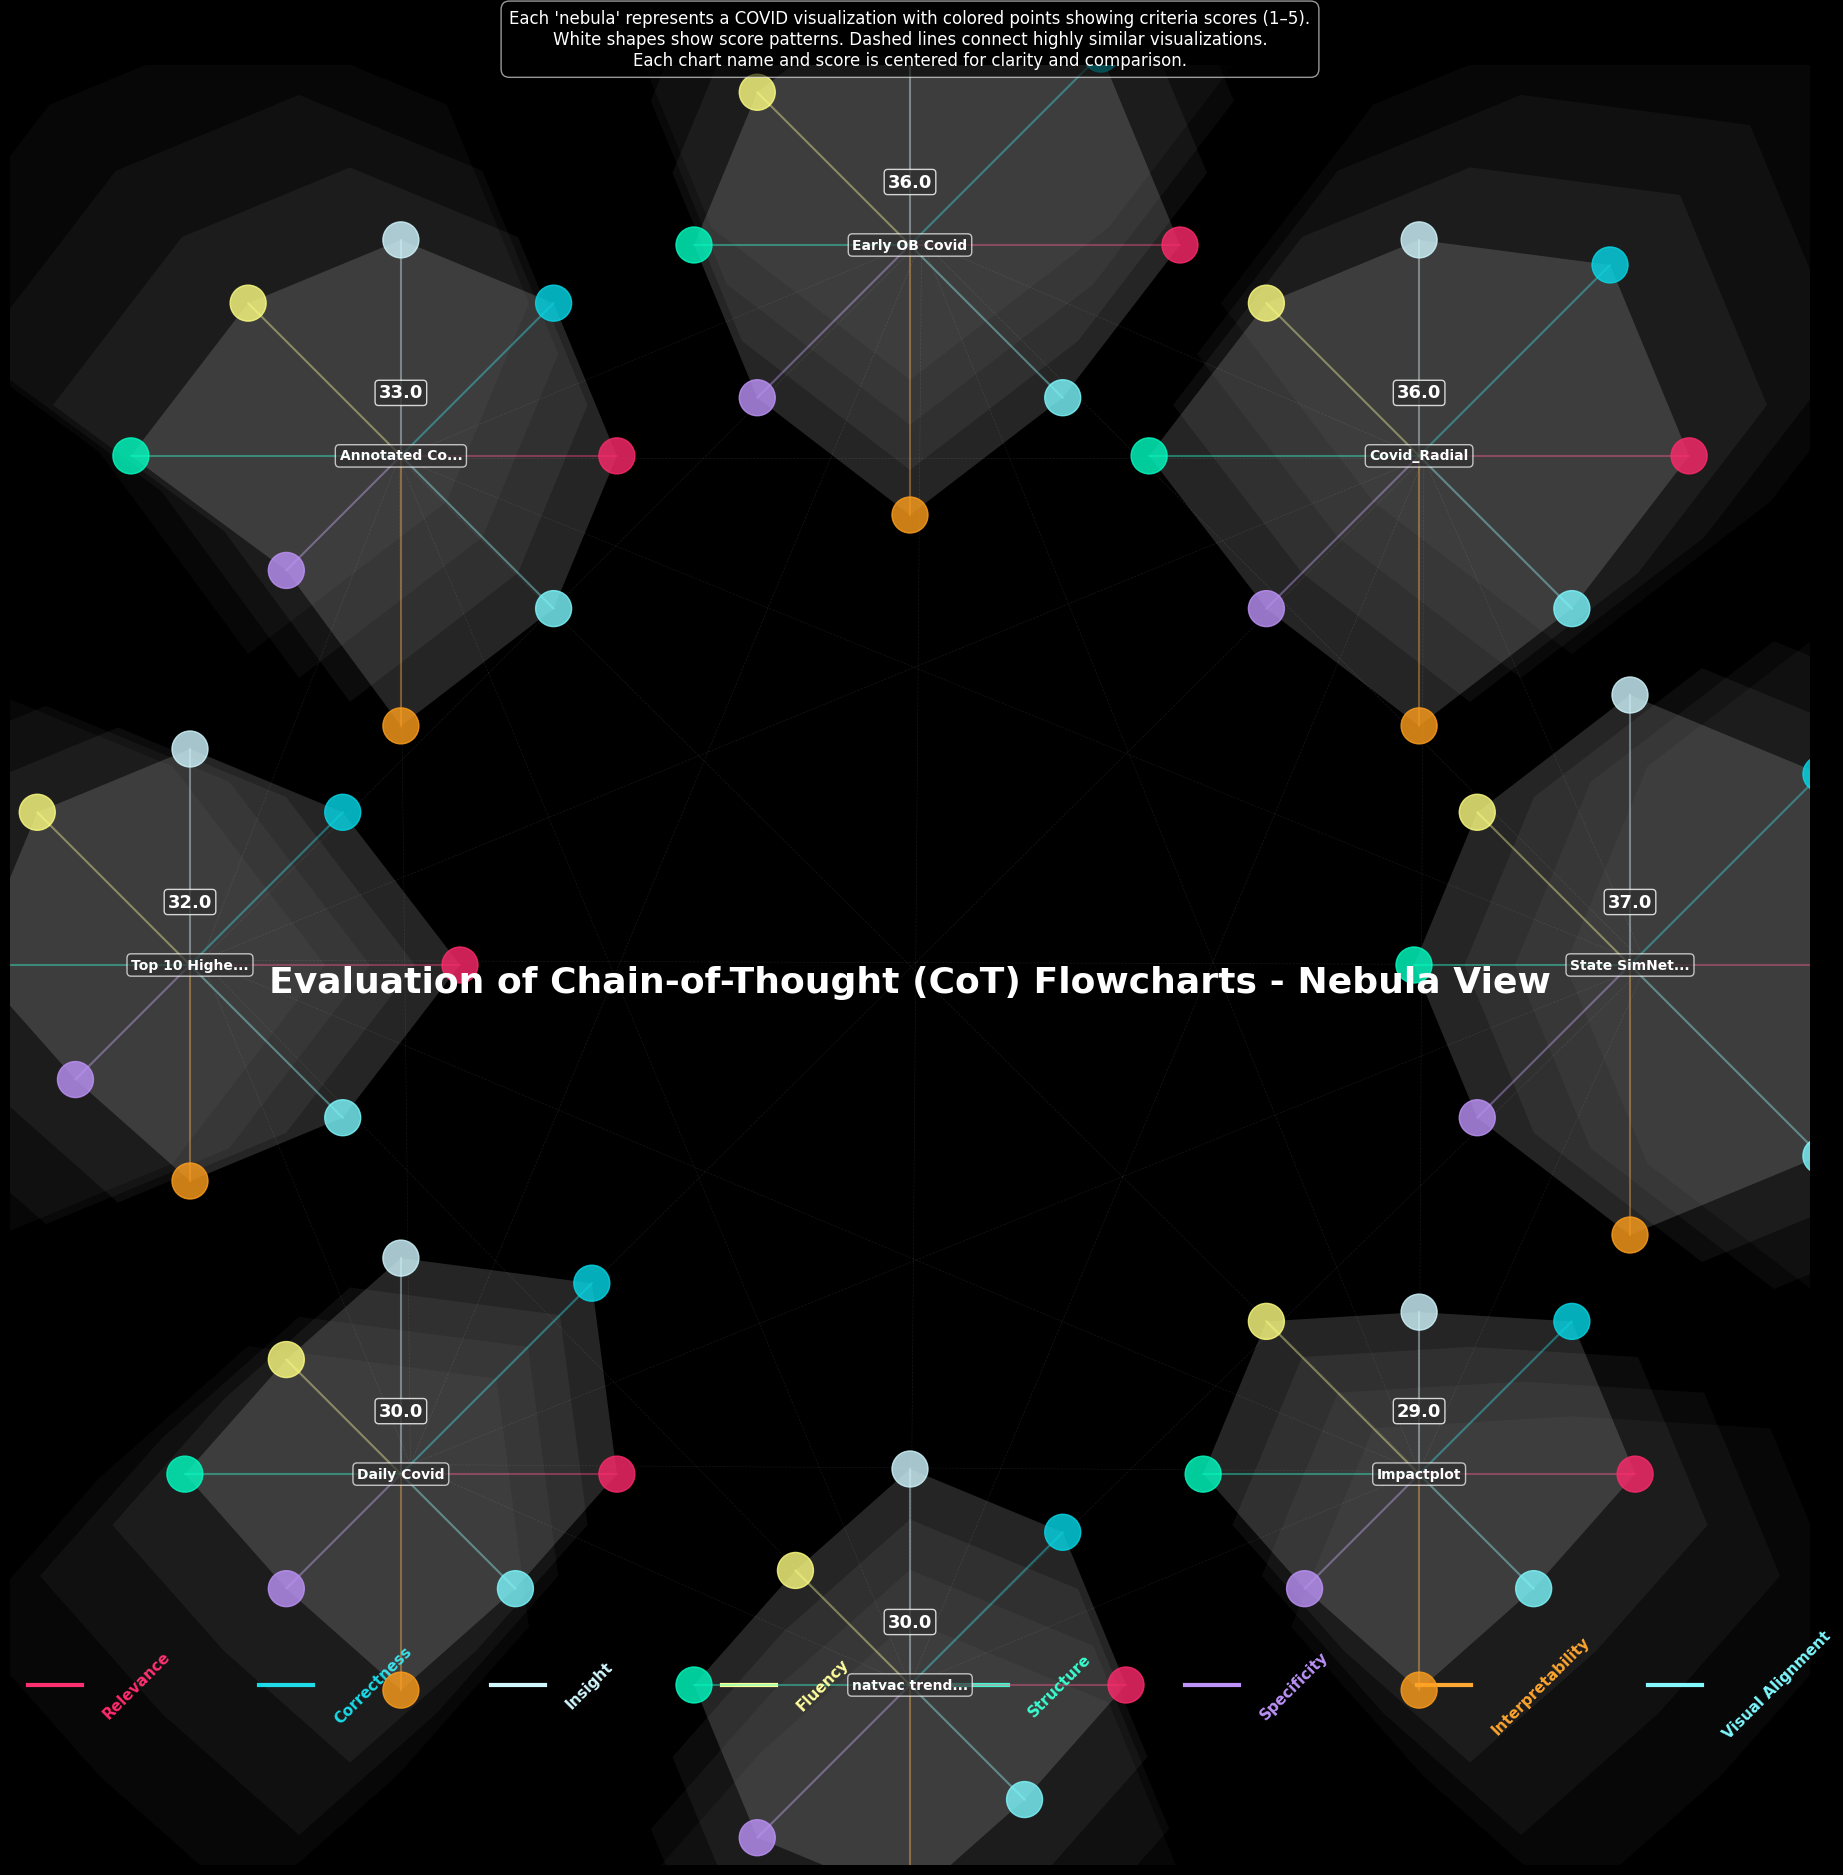

In [26]:
# Re-import required libraries after code execution state reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.transforms import Affine2D

# Define mock scores
mock_scores = {
    "Covid_Radial":       [5, 5, 4, 4, 5, 4, 5, 4],
    "Annotated Covid timeline": [4, 4, 4, 4, 5, 3, 5, 4],
    "Daily Covid":        [4, 5, 4, 3, 4, 3, 4, 3],
    "Early OB Covid":     [5, 5, 5, 4, 4, 4, 5, 4],
    "Top 10 Highest Covid": [5, 4, 4, 4, 4, 3, 4, 4],
    "Impactplot":         [4, 4, 3, 4, 4, 3, 4, 3],
    "Outlier Covid":      [3, 3, 3, 3, 3, 3, 4, 3],
    "State SimNet Covid": [5, 5, 5, 4, 4, 4, 5, 5],
    "natvac trend covid": [4, 4, 4, 3, 4, 4, 4, 3],
    "vacrvcumdea":        [3, 3, 3, 3, 3, 3, 3, 3]
}

criteria = ["Relevance", "Correctness", "Insight", "Fluency",
            "Structure", "Specificity", "Interpretability", "Visual Alignment"]

# Define rubric and scores
criteria = ["Relevance", "Correctness", "Insight", "Fluency",
            "Structure", "Specificity", "Interpretability", "Visual Alignment"]

mock_scores = {
    "Covid_Radial": [5, 5, 4, 4, 5, 4, 5, 4],
    "Annotated Covid timeline": [4, 4, 4, 4, 5, 3, 5, 4],
    "Daily Covid": [4, 5, 4, 3, 4, 3, 4, 3],
    "Early OB Covid": [5, 5, 5, 4, 4, 4, 5, 4],
    "Top 10 Highest Covid": [5, 4, 4, 4, 4, 3, 4, 4],
    "Impactplot": [4, 4, 3, 4, 4, 3, 4, 3],
    "Outlier Covid": [3, 3, 3, 3, 3, 3, 4, 3],
    "State SimNet Covid": [5, 5, 5, 4, 4, 4, 5, 5],
    "natvac trend covid": [4, 4, 4, 3, 4, 4, 4, 3],
    "vacrvcumdea": [3, 3, 3, 3, 3, 3, 3, 3]
}

# Create DataFrame and compute totals
df_cot = pd.DataFrame.from_dict(mock_scores, orient='index', columns=criteria)
df_cot["Total"] = df_cot[criteria].sum(axis=1)
df_cot = df_cot.sort_values("Total", ascending=False)

# Visualization settings
plt.style.use("dark_background")
fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
ax = plt.subplot(111)
ax.set_facecolor("black")

# Colors for rubric criteria
base_colors = [
    '#FF2A6D', '#05D9E8', '#D1F7FF', '#FFFF82',
    '#01FFC3', '#BD93F9', '#FF9F1C', '#7DF9FF'
]

# Layout setup
charts = df_cot.index.tolist()[:8]
num_charts = len(charts)
radius = 8
chart_angles = np.linspace(0, 2 * np.pi, num_charts, endpoint=False)
chart_positions = dict(zip(charts, zip(radius * np.cos(chart_angles), radius * np.sin(chart_angles))))
chart_centroids = {}

# Draw each chart as a nebula
for c_idx, chart in enumerate(charts):
    cx, cy = chart_positions[chart]
    scores = df_cot.loc[chart, criteria].values
    points_x, points_y = [], []
    centroid_x, centroid_y = 0, 0

    for i, (criterion, score) in enumerate(zip(criteria, scores)):
        angle = 2 * np.pi * (i / len(criteria))
        distance = score * 0.6
        px, py = cx + distance * np.cos(angle), cy + distance * np.sin(angle)
        points_x.append(px)
        points_y.append(py)
        centroid_x += px
        centroid_y += py
        ax.add_patch(plt.Circle((px, py), 0.2, color=base_colors[i], alpha=0.8, zorder=10))
        ax.plot([cx, px], [cy, py], color=base_colors[i], alpha=0.4, linewidth=1.5)

        # Draw legend once (only for the first chart)
        if c_idx == 0:
            label_x = -9 + 18 * (i / (len(criteria) - 1))
            label_y = -8
            ax.plot([label_x - 0.8, label_x - 0.2], [label_y, label_y], color=base_colors[i], linewidth=3)
            ax.text(label_x, label_y, criterion, ha='left', va='center', color=base_colors[i],
                    fontsize=11, fontweight='bold', rotation=45)

    # Compute centroid
    centroid_x /= len(criteria)
    centroid_y /= len(criteria)
    chart_centroids[chart] = (centroid_x, centroid_y)

    # Close polygon and add shape
    points_x.append(points_x[0])
    points_y.append(points_y[0])
    total_score = df_cot.loc[chart, "Total"]

    polygon = plt.Polygon(list(zip(points_x, points_y)), closed=True, alpha=0.15,
                          facecolor='white', edgecolor='none', zorder=5)
    ax.add_patch(polygon)

    # Add glow effect
    for i in range(3):
        glow = plt.Polygon(list(zip(points_x, points_y)), closed=True,
                           alpha=0.05 - i * 0.01, facecolor='white', edgecolor='none', zorder=4 - i)
        scale = Affine2D().scale(1.1 + i * 0.1)
        glow.set_transform(scale + ax.transData)
        ax.add_patch(glow)

    # Chart labels and score
    ax.text(cx, cy, chart if len(chart) < 15 else chart[:12] + "...", ha='center', va='center',
            color='white', fontsize=10, fontweight='bold',
            bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=0.3'))
    ax.text(cx, cy + 0.7, f"{total_score:.1f}", ha='center', va='center',
            color='white', fontsize=13, fontweight='bold',
            bbox=dict(facecolor='black', alpha=0.8, edgecolor='white', linewidth=1, boxstyle='round,pad=0.2'))

# Draw similarity edges between highly similar charts
for i, chart1 in enumerate(charts):
    c1x, c1y = chart_centroids[chart1]
    for j, chart2 in enumerate(charts):
        if i < j:
            c2x, c2y = chart_centroids[chart2]
            scores1 = df_cot.loc[chart1, criteria].values
            scores2 = df_cot.loc[chart2, criteria].values
            similarity = np.dot(scores1, scores2) / (np.linalg.norm(scores1) * np.linalg.norm(scores2))
            if similarity > 0.95:
                ax.plot([c1x, c2x], [c1y, c2y], color='white', alpha=similarity - 0.9,
                        linewidth=similarity * 0.5, linestyle='--', zorder=1)

# Final formatting
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.axis('off')

# Title and description
plt.suptitle("Evaluation of Chain-of-Thought (CoT) Flowcharts - Nebula View", fontsize=26, fontweight='bold', y=0.50)
description = (
    "Each 'nebula' represents a COVID visualization with colored points showing criteria scores (1–5).\n"
    "White shapes show score patterns. Dashed lines connect highly similar visualizations.\n"
    "Each chart name and score is centered for clarity and comparison."
)
plt.figtext(0.5, 0.95, description, ha='center', fontsize=12, color='white',
            bbox=dict(facecolor='black', alpha=0.6, edgecolor='white', boxstyle='round,pad=0.5'))

plt.show()


## Cell 18: Chart Clustering by Reasoning Summary Complexity

This visualization shows how charts cluster based on the **semantic content and complexity** of their Chain-of-Thought (CoT) summaries.

Process:
1. The two one-sentence summaries for each chart were concatenated.
2. A Bag-of-Words vector was generated (excluding stopwords).
3. PCA reduced the dimensionality of the summaries into a 2D space.
4. Charts are plotted based on semantic proximity in the reasoning space.

Interpretation:
- Charts close together used **similar reasoning language or structure**.
- Outliers may represent **unique logic types**, e.g., focusing on labels vs. trends.
- This map highlights **variation in explanation style**, not score values.

In [27]:
print(df.columns)
print(df.index.names)

Index(['Chart', 'Question #', 'Relevance', 'Clarity', 'Faithfulness',
       'Initial Answer', 'Answer After CoT', 'Changed?', 'Confidence Boost?',
       'Mentions Axis?', 'Mentions Labels?', 'Mentions Trends?',
       'Graph Renders?', 'Logical Flow?', 'Final Answer Node?',
       '1-Sentence Summary'],
      dtype='object')
[None]


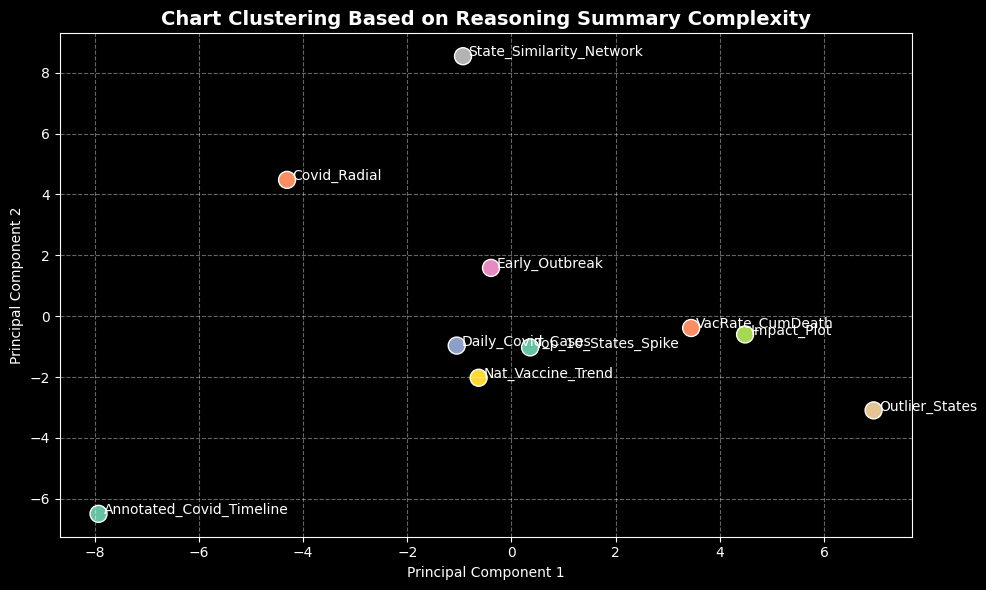

In [28]:
# Safe check: ensure Chart is a column and not an index
if "Chart" not in df.columns:
    df = df.reset_index()

# Drop potential leftover index column
if "level_0" in df.columns:
    df = df.drop(columns=["level_0"])

# Group and join summaries per chart
summary_text = df.groupby("Chart")["1-Sentence Summary"].apply(lambda x: " ".join(x))


# Step 2: Convert text summaries into a Bag-of-Words vector (ignoring stopwords)
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(summary_text)

# Step 3: Normalize and reduce dimensions using PCA
X_scaled = StandardScaler(with_mean=False).fit_transform(X)
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled.toarray())

# Step 4: Wrap into a DataFrame for plotting
pca_df = pd.DataFrame(components, columns=["PC1", "PC2"])
pca_df["Chart"] = summary_text.index

# Step 5: Scatterplot of chart positions in PCA space
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Chart", s=150, palette="Set2", legend=False)

# Annotate chart names
for i in range(pca_df.shape[0]):
    plt.text(pca_df.loc[i, "PC1"] + 0.1, pca_df.loc[i, "PC2"], pca_df.loc[i, "Chart"], fontsize=10)

# Format plot
plt.title("Chart Clustering Based on Reasoning Summary Complexity", fontsize=14, weight='bold')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

#### PCA-Based Clustering of COVID Chart Reasoning Complexity

This scatterplot visualizes COVID-19 charts based on the semantic complexity of their reasoning summaries.

We applied **Principal Component Analysis (PCA)** on the Bag-of-Words representation of all one-sentence CoT summaries, allowing us to reduce high-dimensional textual variation into two principal components:

- **X-axis (PC1):** Captures overall language or concept richness in the reasoning.
- **Y-axis (PC2):** Differentiates charts based on structural or topical divergence.

#### Key Observations:

- **State_Similarity_Network** and **Covid_Radial** are isolated along PC2, suggesting unique reasoning patterns, perhaps due to network-based or radial visual formats.
- **Annotated_Covid_Timeline** is far left on PC1 and PC2, indicating summaries that differ significantly in tone or terminology.
- Charts like **VacRate_CumDeath**, **Impact_Plot**, and **Top_10_States_Spike** cluster tightly, suggesting similar reasoning complexity and vocabulary.

This view helps detect outliers and clusters in reasoning approaches, guiding further analysis or redesign of visualization formats.


## Cell 19: Word Cloud of Reasoning Summary Keywords

The word cloud below highlights the most common words used in the one-sentence Chain-of-Thought (CoT) summaries across all chart evaluations.

**Larger words indicate higher frequency across all reasoning explanations.**

This helps:
- Identify dominant reasoning strategies (e.g., “compared”, “identified”, “labels”, “trend”)
- Reveal which visual cues or interpretation tactics were most prevalent across the dataset


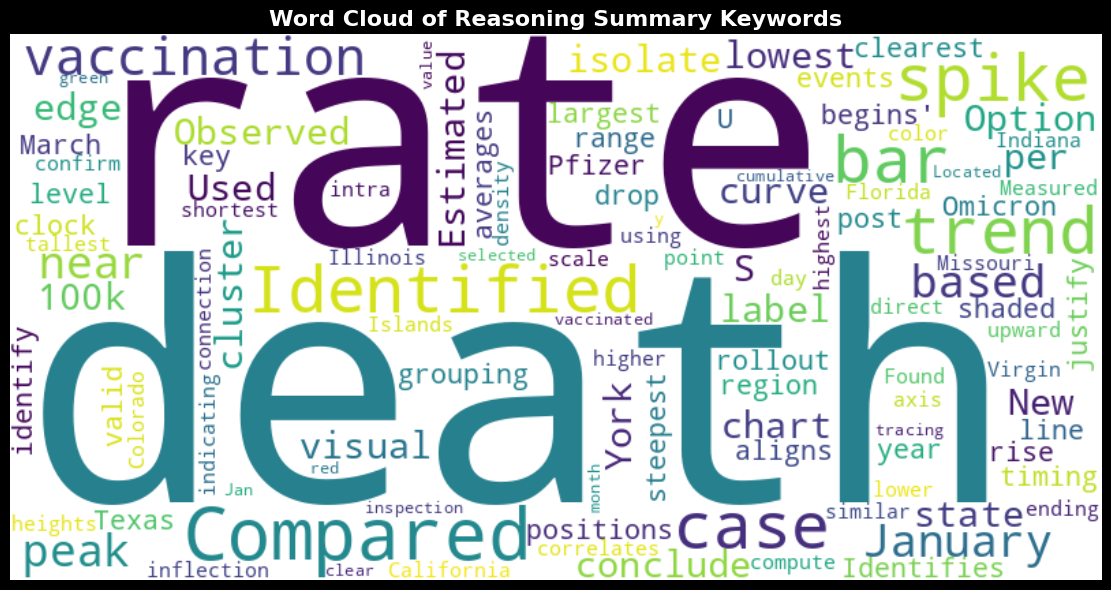

In [29]:
# Combine all 1-sentence summaries into a single string
all_text = " ".join(df["1-Sentence Summary"].tolist())

# Generate a word cloud from the combined text
wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='viridis'  # consistent with earlier visuals
).generate(all_text)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Reasoning Summary Keywords", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# EVA

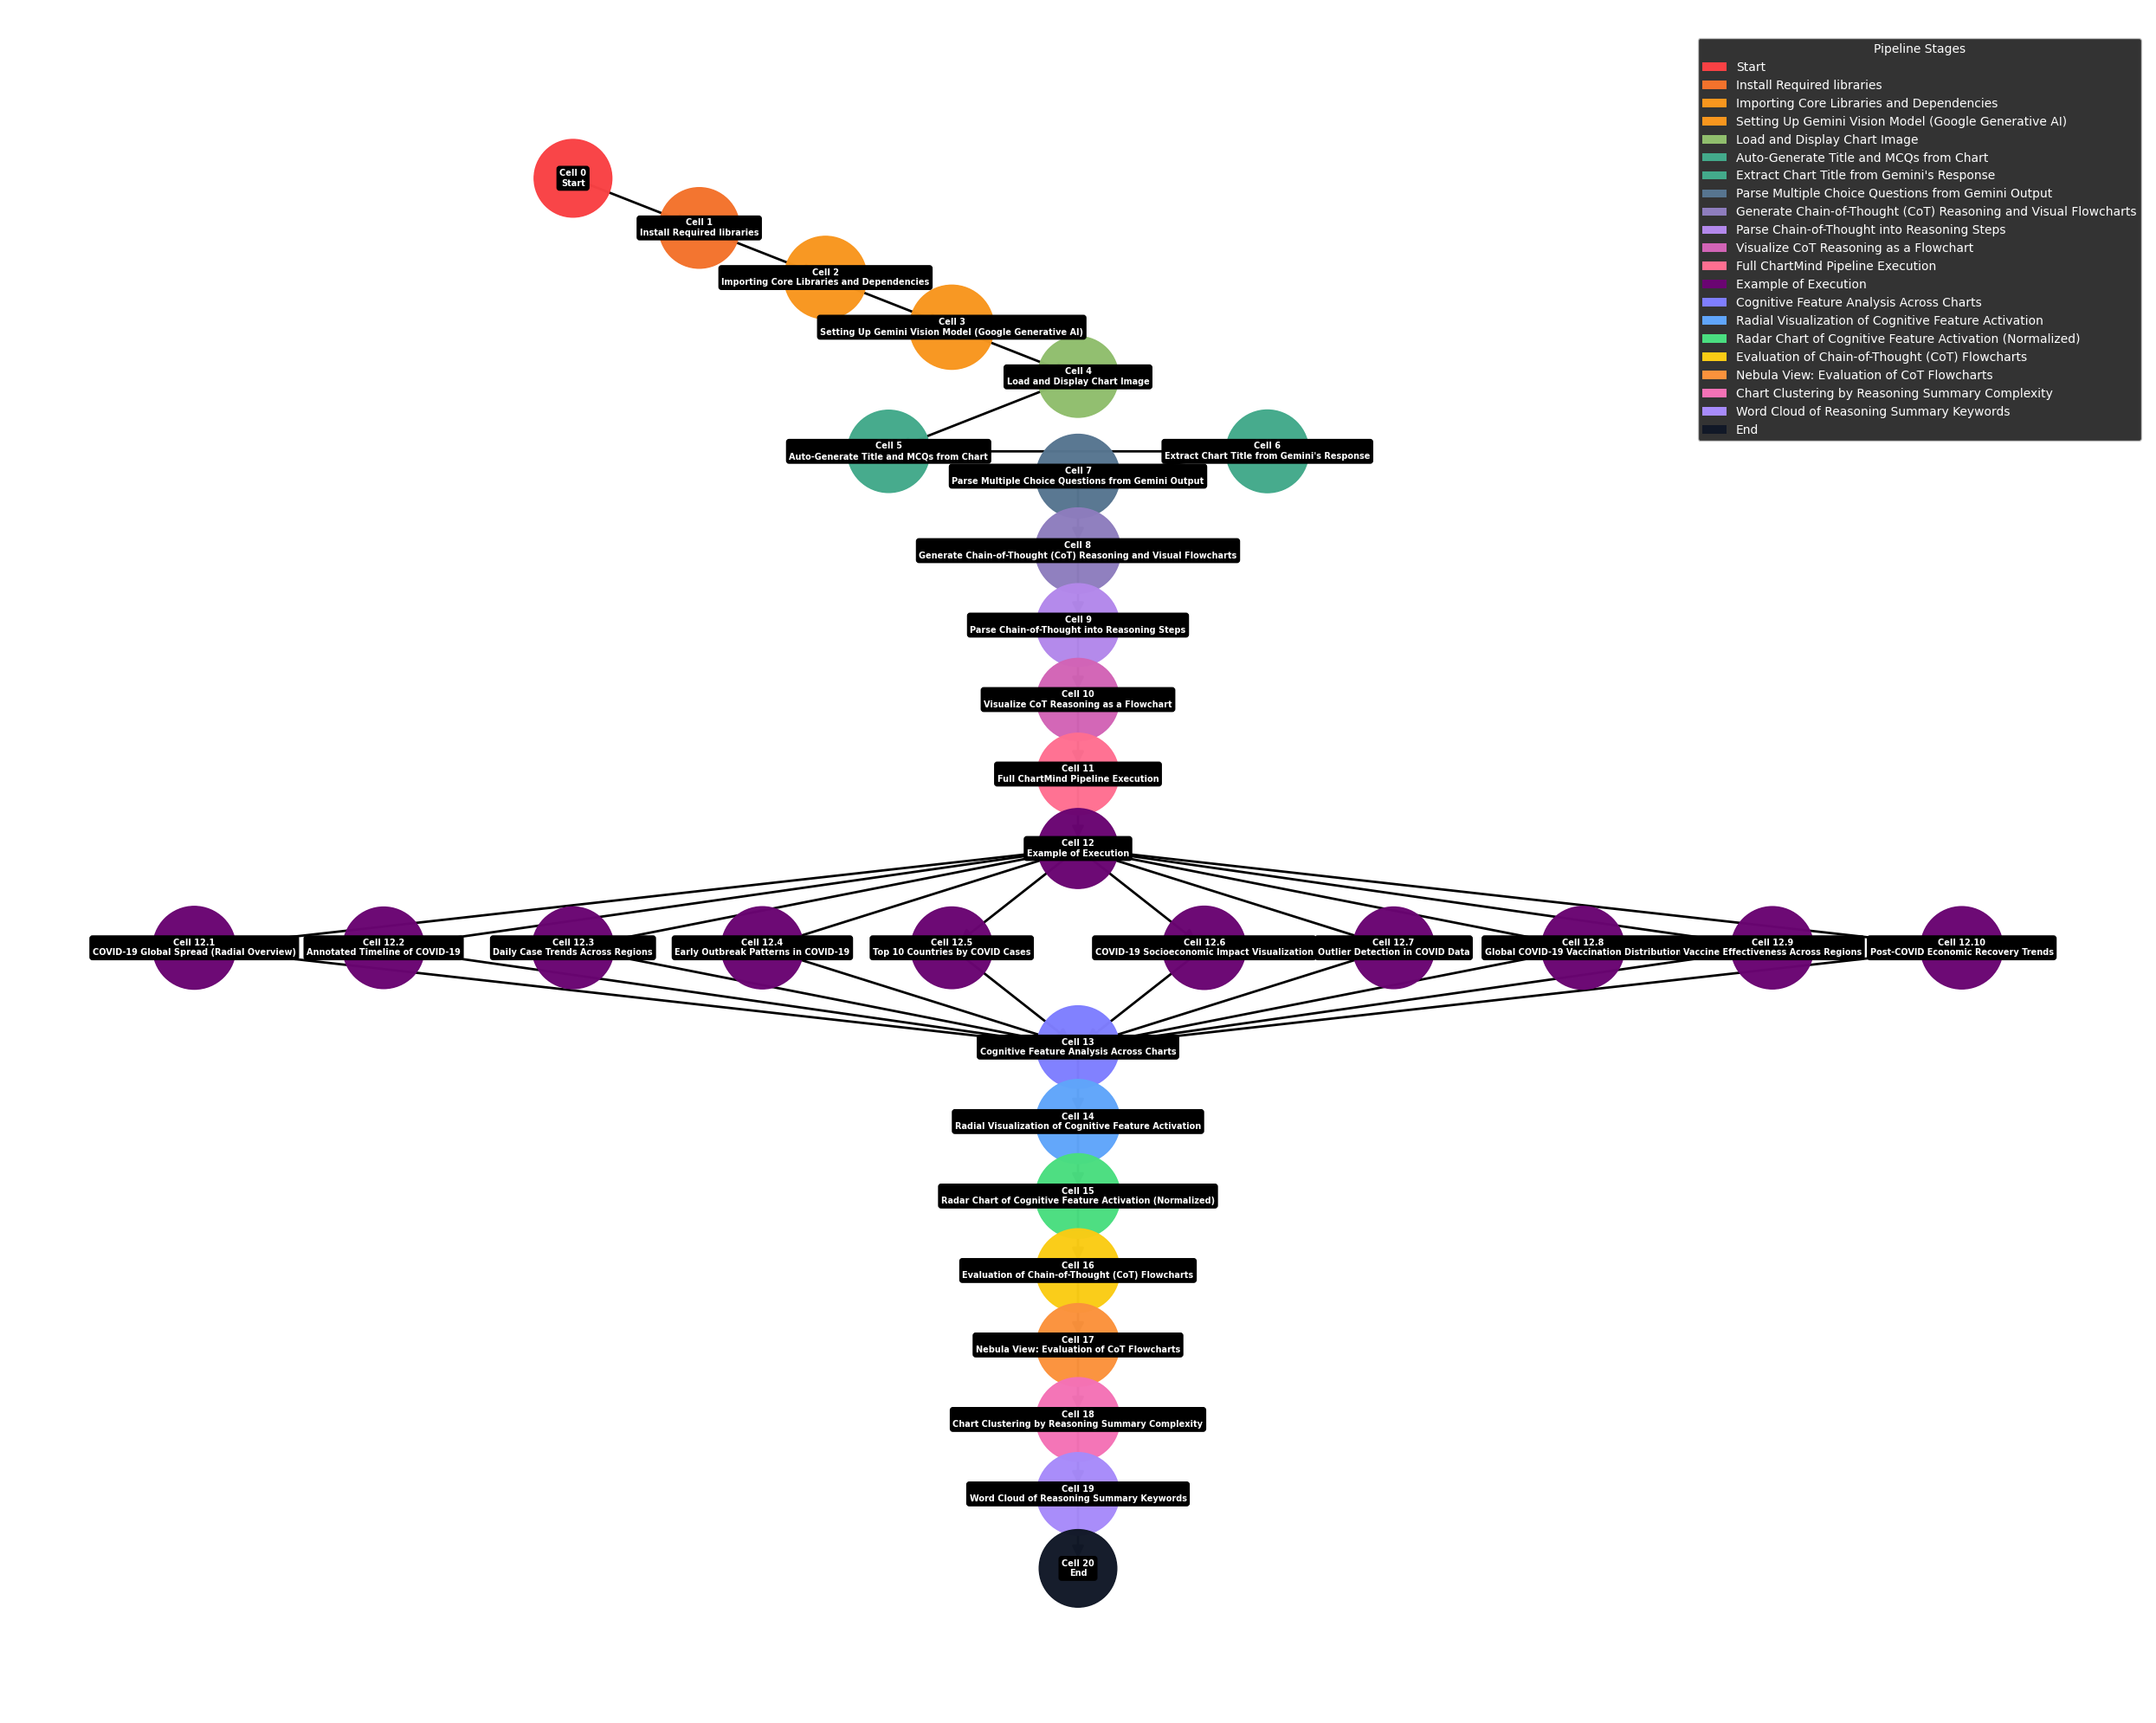

In [34]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Patch

# Create a directed graph
G = nx.DiGraph()

# Define labeled nodes
nodes = {
    "0": "Cell 0\nStart",
    "1": "Cell 1\nInstall Required libraries",
    "2": "Cell 2\nImporting Core Libraries and Dependencies",
    "3": "Cell 3\nSetting Up Gemini Vision Model (Google Generative AI)",
    "4": "Cell 4\nLoad and Display Chart Image",
    "5": "Cell 5\nAuto-Generate Title and MCQs from Chart",
    "6": "Cell 6\nExtract Chart Title from Gemini's Response",
    "7": "Cell 7\nParse Multiple Choice Questions from Gemini Output",
    "8": "Cell 8\nGenerate Chain-of-Thought (CoT) Reasoning and Visual Flowcharts",
    "9": "Cell 9\nParse Chain-of-Thought into Reasoning Steps",
    "10": "Cell 10\nVisualize CoT Reasoning as a Flowchart",
    "11": "Cell 11\nFull ChartMind Pipeline Execution",
    "12": "Cell 12\nExample of Execution",
    "12.1": "Cell 12.1\nCOVID-19 Global Spread (Radial Overview)",
    "12.2": "Cell 12.2\nAnnotated Timeline of COVID-19",
    "12.3": "Cell 12.3\nDaily Case Trends Across Regions",
    "12.4": "Cell 12.4\nEarly Outbreak Patterns in COVID-19",
    "12.5": "Cell 12.5\nTop 10 Countries by COVID Cases",
    "12.6": "Cell 12.6\nCOVID-19 Socioeconomic Impact Visualization",
    "12.7": "Cell 12.7\nOutlier Detection in COVID Data",
    "12.8": "Cell 12.8\nGlobal COVID-19 Vaccination Distribution",
    "12.9": "Cell 12.9\nVaccine Effectiveness Across Regions",
    "12.10": "Cell 12.10\nPost-COVID Economic Recovery Trends",
    "13": "Cell 13\nCognitive Feature Analysis Across Charts",
    "14": "Cell 14\nRadial Visualization of Cognitive Feature Activation",
    "15": "Cell 15\nRadar Chart of Cognitive Feature Activation (Normalized)",
    "16": "Cell 16\nEvaluation of Chain-of-Thought (CoT) Flowcharts",
    "17": "Cell 17\nNebula View: Evaluation of CoT Flowcharts",
    "18": "Cell 18\nChart Clustering by Reasoning Summary Complexity",
    "19": "Cell 19\nWord Cloud of Reasoning Summary Keywords",
    "20": "Cell 20\nEnd"
}
for node, label in nodes.items():
    G.add_node(node, label=label)

# Define edges (flow)
edges = [
    ("0", "1"), ("1", "2"), ("2", "3"), ("3", "4"), ("4", "5"), ("5", "6"),
    ("6", "7"), ("7", "8"), ("8", "9"), ("9", "10"), ("10", "11"), ("11", "12"),
    ("12", "12.1"), ("12", "12.2"), ("12", "12.3"), ("12", "12.4"), ("12", "12.5"),
    ("12", "12.6"), ("12", "12.7"), ("12", "12.8"), ("12", "12.9"), ("12", "12.10"),
    ("12.1", "13"), ("12.2", "13"), ("12.3", "13"), ("12.4", "13"), ("12.5", "13"),
    ("12.6", "13"), ("12.7", "13"), ("12.8", "13"), ("12.9", "13"), ("12.10", "13"),
    ("13", "14"), ("14", "15"), ("15", "16"), ("16", "17"),
    ("17", "18"), ("18", "19"), ("19", "20")
]
G.add_edges_from(edges)

# Layout with more spacing
pos = {
    "0": (-4.0, 10.0),
    "1": (-3.0, 9.0),
    "2": (-2.0, 8.0),
    "3": (-1.0, 7.0),
    "4": (0.0, 6.0),
    "5": (-1.5, 4.5),
    "6": (1.5, 4.5),
    "7": (0.0, 4.0),
    "8": (0.0, 2.5),
    "9": (0.0, 1.0),
    "10": (0.0, -0.5),
    "11": (0.0, -2.0),
    "12": (0.0, -3.5),
    "12.1": (-7.0, -5.5), "12.2": (-5.5, -5.5), "12.3": (-4.0, -5.5),
    "12.4": (-2.5, -5.5), "12.5": (-1.0, -5.5), "12.6": (1.0, -5.5),
    "12.7": (2.5, -5.5), "12.8": (4.0, -5.5), "12.9": (5.5, -5.5), "12.10": (7.0, -5.5),
    "13": (0.0, -7.5), "14": (0.0, -9.0), "15": (0.0, -10.5),
    "16": (0.0, -12.0), "17": (0.0, -13.5), "18": (0.0, -15.0),
    "19": (0.0, -16.5), "20": (0.0, -18.0)
}

# Section colors
section_colors = {
    "0": "#F94144", "1": "#F3722C", "2": "#F8961E", "3": "#F8961E",
    "4": "#90BE6D", "5": "#43AA8B", "6": "#43AA8B", "7": "#577590",
    "8": "#8E7DBE", "9": "#B388EB", "10": "#D264B6", "11": "#FF6F91",
    "12": "#6A0572", "13": "#7F7EFF", "14": "#60A5FA", "15": "#4ADE80",
    "16": "#FACC15", "17": "#FB923C", "18": "#F472B6", "19": "#A78BFA", "20": "#111827"
}
node_colors = [section_colors[node.split('.')[0]] for node in G.nodes]

# Node sizes
labels = nx.get_node_attributes(G, "label")
node_sizes = [4000 + len(label) * 15 for label in labels.values()]

# Draw with white background
fig = plt.figure(figsize=(25, 20), facecolor='white')
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('white')

nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colors, node_size=node_sizes, alpha=0.98)
nx.draw_networkx_edges(G, pos, ax=ax, edge_color="black", arrows=True, arrowstyle="-|>", arrowsize=20, width=2)

for node, (x, y) in pos.items():
    ax.text(
        x, y, labels[node], fontsize=7, fontweight='bold',
        ha='center', va='center',
        bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.3')
    )

# Title
ax.set_title("EVA Graph: COVID-19 ChartMind Reasoning Pipeline", fontsize=18, fontweight="bold")
ax.axis("off")

# Legend
legend_elements = [
    Patch(facecolor=section_colors[str(k)], label=nodes[str(k)].split('\n')[1])
    for k in range(21)
]
ax.legend(handles=legend_elements, loc='upper right', frameon=True, title="Pipeline Stages")

plt.tight_layout()
plt.show()